In [289]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None)    # None means no limit
pd.set_option('display.max_columns', None)    # None means no limit
from functions_variables import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import pickle
from xgboost import XGBClassifier


In [172]:
# Load data
df = pd.read_csv('../data/preprocessed/macro_finance_data_2014_2023.csv')
df.tail()

,Date,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield
3221,2024-02-19,78.11,1.558,2197.0,3.8110,2027.5,905.65,23.003,565.0,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17092.26,4763.07,7728.50,15775.65,38470.38,2032.74,5005.57,21255.61,111.27,1.4536,1.6985,1.3488,3.1
3222,2024-02-20,78.18,1.576,2193.5,3.8675,2039.8,914.30,23.136,556.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17068.43,4760.28,7719.21,15630.78,38363.61,2004.14,4975.51,21217.53,110.89,1.4606,1.7060,1.3520,3.1
3223,2024-02-21,77.91,1.773,2219.5,3.8750,2034.3,889.60,22.874,560.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17118.12,4775.31,7662.51,15580.87,38262.16,1994.74,4981.80,21172.38,111.27,1.4608,1.7062,1.3505,3.1
3224,2024-02-22,78.61,1.732,2198.0,3.8970,2030.7,905.50,22.784,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17370.45,4855.36,7684.49,16041.62,39098.68,2013.84,5087.03,21318.08,111.64,1.4590,1.7066,1.3481,3.1
3225,2024-02-23,76.49,1.603,2180.0,3.8800,2049.4,909.60,22.982,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17419.33,4872.57,7706.28,15996.82,39098.68,2016.69,5088.80,21413.15,111.42,1.4610,1.7112,1.3505,3.1


### Create Target Variable for TSX Index if Index has Increased from the Prior Day

In [173]:
df['Index Up'] = df['TSX'] > df['TSX'].shift(1)
df.head(10)

,Date,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up
0,2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False
1,2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False
2,2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False
3,2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False
4,2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False
5,2014-01-06,93.43,4.306,1840.25,3.3595,1238.0,1415.60,20.103,352.0,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9428.00,3069.16,6730.73,4113.68,15908.88,1147.16,1826.77,13495.54,97.81,1.4522,1.7481,1.0655,2.72,False
6,2014-01-07,93.67,4.299,1840.25,3.3595,1229.6,1413.65,19.787,354.2,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9506.20,3110.96,6755.45,4153.18,15814.37,1157.63,1837.88,13596.93,97.18,1.4658,1.7658,1.0766,2.67,True
7,2014-01-08,92.33,4.216,1840.25,3.3425,1225.5,1416.65,19.539,356.0,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9497.84,3110.66,6721.78,4165.61,16121.45,1157.46,1837.49,13614.63,96.91,1.4688,1.7795,1.0819,2.72,True
8,2014-01-09,91.66,4.005,1840.25,3.2990,1229.4,1418.90,19.683,365.5,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9421.61,3090.26,6691.34,4156.19,15880.33,1158.35,1838.13,13629.41,96.70,1.4751,1.7866,1.0840,2.68,True
9,2014-01-10,92.72,4.053,1840.25,3.3415,1246.9,1437.35,20.223,362.2,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9473.24,3104.15,6739.94,4174.66,15912.06,1164.53,1842.37,13747.52,95.60,1.4892,1.7956,1.0895,2.56,True


## For EDA set the date as the index to leverage time series specific methods for understanding the data

In [174]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [175]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayofWeek'] = df.index.dayofweek
df.tail()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-19,78.11,1.558,2197.0,3.8110,2027.5,905.65,23.003,565.0,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17092.26,4763.07,7728.50,15775.65,38470.38,2032.74,5005.57,21255.61,111.27,1.4536,1.6985,1.3488,3.1,False,2024,2,19,0
2024-02-20,78.18,1.576,2193.5,3.8675,2039.8,914.30,23.136,556.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17068.43,4760.28,7719.21,15630.78,38363.61,2004.14,4975.51,21217.53,110.89,1.4606,1.7060,1.3520,3.1,False,2024,2,20,1
2024-02-21,77.91,1.773,2219.5,3.8750,2034.3,889.60,22.874,560.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17118.12,4775.31,7662.51,15580.87,38262.16,1994.74,4981.80,21172.38,111.27,1.4608,1.7062,1.3505,3.1,False,2024,2,21,2
2024-02-22,78.61,1.732,2198.0,3.8970,2030.7,905.50,22.784,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17370.45,4855.36,7684.49,16041.62,39098.68,2013.84,5087.03,21318.08,111.64,1.4590,1.7066,1.3481,3.1,True,2024,2,22,3
2024-02-23,76.49,1.603,2180.0,3.8800,2049.4,909.60,22.982,564.5,5.0,2215040.0,158.3,124.3,62379.9,6.1,117287179.0,2.795700e+13,62696.0,17419.33,4872.57,7706.28,15996.82,39098.68,2016.69,5088.80,21413.15,111.42,1.4610,1.7112,1.3505,3.1,True,2024,2,23,4


In [176]:
with open('../data/models/baseline.pkl', 'wb') as file:
    pickle.dump(df, file)

In [6]:
# create a dataframe that only includes the weekdays
# commodities and currency are traded on weekend, but the index is only traded during the week, therefore the number of False values will be present 
# if the weekends are included and distort the percentage of index up calculations
df_weekdays = df[df['DayofWeek'] < 5]
df_weekdays.tail(30)

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-15,72.79,3.066,2204.5,3.7782,2057.85,921.35,23.328,559.0,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16622.22,4454.68,7594.91,14972.76,35901.79,1950.96,4783.83,21061.88,108.52,1.4698,1.7083,1.3424,3.1,True,2024,1,15,0
2024-01-16,72.40,2.900,2214.0,3.7665,2039.70,904.40,22.983,554.5,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16571.68,4446.51,7558.34,14944.35,35619.18,1927.30,4762.85,20948.09,109.03,1.4671,1.7048,1.3492,3.1,False,2024,1,16,1
2024-01-17,72.56,2.870,2178.0,3.7330,2015.90,889.60,22.559,546.5,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16431.69,4403.08,7446.29,14855.62,35477.75,1913.17,4739.21,20695.02,109.69,1.4695,1.7114,1.3505,3.1,False,2024,1,17,2
2024-01-18,74.08,2.697,2163.5,3.7450,2031.10,912.00,22.699,547.5,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16567.35,4453.05,7459.09,15055.65,35466.17,1923.65,4780.94,20756.73,109.84,1.4664,1.7133,1.3485,3.1,True,2024,1,18,3
2024-01-19,73.41,2.519,2166.0,3.7865,2038.50,907.00,22.601,548.0,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16555.13,4448.83,7461.93,15310.97,35963.27,1944.39,4839.81,20906.52,110.30,1.4634,1.7055,1.3429,3.1,True,2024,1,19,4
2024-01-22,75.19,2.419,2159.0,3.7635,2031.50,903.00,22.183,551.5,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16683.36,4480.32,7487.71,15360.29,36546.95,1983.38,4850.43,20924.30,109.87,1.4665,1.7129,1.3478,3.1,True,2024,1,22,0
2024-01-23,74.37,2.450,2228.0,3.7935,2035.20,905.50,22.354,567.5,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16627.09,4465.91,7485.73,15425.94,36517.57,1976.27,4864.60,21034.59,110.21,1.4600,1.7063,1.3460,3.1,True,2024,1,23,1
2024-01-24,75.09,2.641,2229.5,3.8860,2025.40,914.90,22.769,565.5,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16889.92,4564.11,7527.67,15481.92,36226.48,1961.86,4868.55,21025.78,109.04,1.4716,1.7205,1.3522,3.1,False,2024,1,24,2
2024-01-25,77.36,2.571,2238.5,3.8690,2027.10,894.50,22.814,574.0,5.0,2203489.0,158.3,124.4,64374.7,5.3,116850619.0,2.795700e+13,62696.0,16906.92,4582.26,7529.73,15510.50,36236.47,1975.88,4894.16,21101.54,109.57,1.4614,1.7123,1.3474,3.1,True,2024,1,25,3


In [7]:
#group index up by month
grouped = df_weekdays.groupby(['Year','Month'])['Index Up'].sum()
print(grouped)

Year  Month
2014  1        12
      2        14
      3        12
      4        12
      5        11
      6        17
      7        13
      8        12
      9         6
      10       10
      11       13
      12       11
2015  1        12
      2        12
      3        11
      4        14
      5         9
      6        11
      7        12
      8         8
      9        11
      10       11
      11        8
      12       11
2016  1         9
      2        10
      3        13
      4        11
      5        10
      6        11
      7        14
      8        13
      9        13
      10       10
      11       11
      12       15
2017  1        10
      2        11
      3        13
      4         9
      5        10
      6         9
      7         9
      8        10
      9        12
      10       14
      11       11
      12       12
2018  1        11
      2         8
      3        13
      4        13
      5        15
      6        13
      7        1

In [9]:
#calculate the number of trading days per month
trading_days = df_weekdays.groupby(['Year', 'Month']).size()

# Calculate the percentage of Index Up for each month relative to the total
percentage_index_up = (grouped / trading_days) * 100

# Combine the results into a DataFrame
result = pd.DataFrame({
    'Index Up Sum': grouped,
    'Total Trading Days': trading_days,
    'Percentage of Index Up': percentage_index_up
})
result

Index Up Sum  Total Trading Days  Percentage of Index Up
Year Month                                                          
2014 1                12                  23               52.173913
     2                14                  20               70.000000
     3                12                  21               57.142857
     4                12                  22               54.545455
     5                11                  22               50.000000
     6                17                  21               80.952381
     7                13                  23               56.521739
     8                12                  21               57.142857
     9                 6                  22               27.272727
     10               10                  23               43.478261
     11               13                  20               65.000000
     12               11                  23               47.826087
2015 1                12                  22               54.545455
     2                12                  20               60.000000
     3                11                  22               50.000000
     4                14                  22               63.636364
     5                 9                  21               42.857143
     6                11                  22               50.000000
     7                12                  23               52.173913
     8                 8                  21               38.095238
     9                11                  22               50.000000
     10               11                  22               50.000000
     11                8                  21               38.095238
     12               11                  23               47.826087
2016 1                 9                  21               42.857143
     2                10                  21               47.619048
     3                13                  23               56.521739
     4                11                  21               52.380952
     5                10                  22               45.454545
     6                11                  22               50.000000
     7                14                  21               66.666667
     8                13                  23               56.521739
     9                13                  22               59.090909
     10               10                  21               47.619048
     11               11                  22               50.000000
     12               15                  22               68.181818
2017 1                10                  22               45.454545
     2                11                  20               55.000000
     3                13                  23               56.521739
     4                 9                  20               45.000000
     5                10                  23               43.478261
     6                 9                  22               40.909091
     7                 9                  21               42.857143
     8                10                  23               43.478261
     9                12                  21               57.142857
     10               14                  22               63.636364
     11               11                  22               50.000000
     12               12                  21               57.142857
2018 1                11                  23               47.826087
     2                 8                  20               40.000000
     3                13                  22               59.090909
     4                13                  21               61.904762
     5                15                  23               65.217391
     6                13                  21               61.904762
     7                10                  22               45.454545
     8                12                  23               52.173913
     9    

In [10]:
result.describe()

,Index Up Sum,Total Trading Days,Percentage of Index Up
count,122.000000,122.000000,122.000000
mean,11.483607,21.704918,52.965159
std,2.235083,1.049900,10.286229
min,6.000000,17.000000,27.272727
25%,10.000000,21.000000,45.454545
50%,11.000000,22.000000,52.380952
75%,13.000000,22.000000,59.090909
max,19.000000,23.000000,82.608696


In [11]:
# Calculate the average percentage of index up per trading day for each month for all 10 years combined
month_grouped = result.groupby('Month')['Percentage of Index Up'].mean()
month_grouped

Month
1     56.810054
2     54.676598
3     55.557124
4     56.690476
5     50.362319
6     55.740260
7     52.774327
8     48.572370
9     45.125541
10    50.227743
11    60.093074
12    48.396386
Name: Percentage of Index Up, dtype: float64

In [12]:
month_grouped.mean()

52.91885599610547

In [13]:
# Calculate the average percentage of index up per trading day for each year for all 10 years
year_grouped = result.groupby('Year')['Percentage of Index Up'].mean()
year_grouped

Year
2014    55.171356
2015    49.769120
2016    53.576134
2017    50.051760
2018    49.686147
2019    55.693739
2020    56.918800
2021    55.775849
2022    49.589843
2023    52.271943
2024    59.846547
Name: Percentage of Index Up, dtype: float64

In [14]:
year_grouped.mean()

53.48647609720616

In [15]:
# To determine if there are any specifc days on which the stock index goes up
day_grouped = df_weekdays.groupby('Day')['Index Up'].sum()
day_grouped.sort_values(ascending=False)

Day
15    59
20    52
14    52
4     51
8     50
12    50
16    49
29    48
10    48
17    48
18    47
2     47
5     47
25    46
28    46
11    46
6     45
3     45
26    45
7     45
19    44
24    44
23    43
13    42
9     42
21    42
27    42
22    41
1     40
30    37
31    18
Name: Index Up, dtype: int64

### Date-Time Components Conclusion
<p>The analysis didn't provide any meaningful patterns or trends involved. The index increased slightly more on a daily basis than going down at an average of 52.4% of the time. The maximum month where the index went up was 82.6% of the time in 2019 and the minimum was 2017 September at 27%. During the Covid Pandemic the market actually performed better in 2019-2021 with the index increasing greater than 55% of the time. Monthly fluctions occured, but on average each year the results are similar across all 10 years. It appears that the middle of the month has higher than normal times where the index went up, with the number of days being the highest for those days.</p>

## Time Series Graphing

In [78]:
column_list = df.columns[:-5]
column_list

Index(['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Copper Price',
       'Gold Price', 'Platinum Price', 'Silver Price', 'Lumber Price',
       'Interest_Rate', 'GDP', 'CPI', 'HPI', 'Trade Balance', 'Unemployment',
       'Wholesale Trade', 'US_GDP', 'Housing starts', 'DAX', 'STOXX 50',
       'FTSE 100', 'NASDAQ', 'Nikkei 225', 'Russell 2000', 'S&P 500', 'TSX',
       'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield'],
      dtype='object')

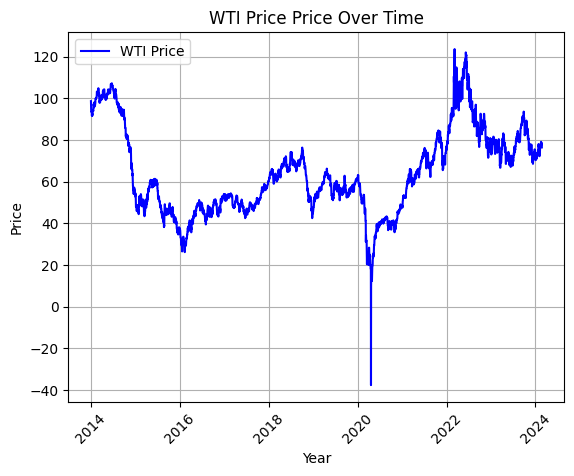

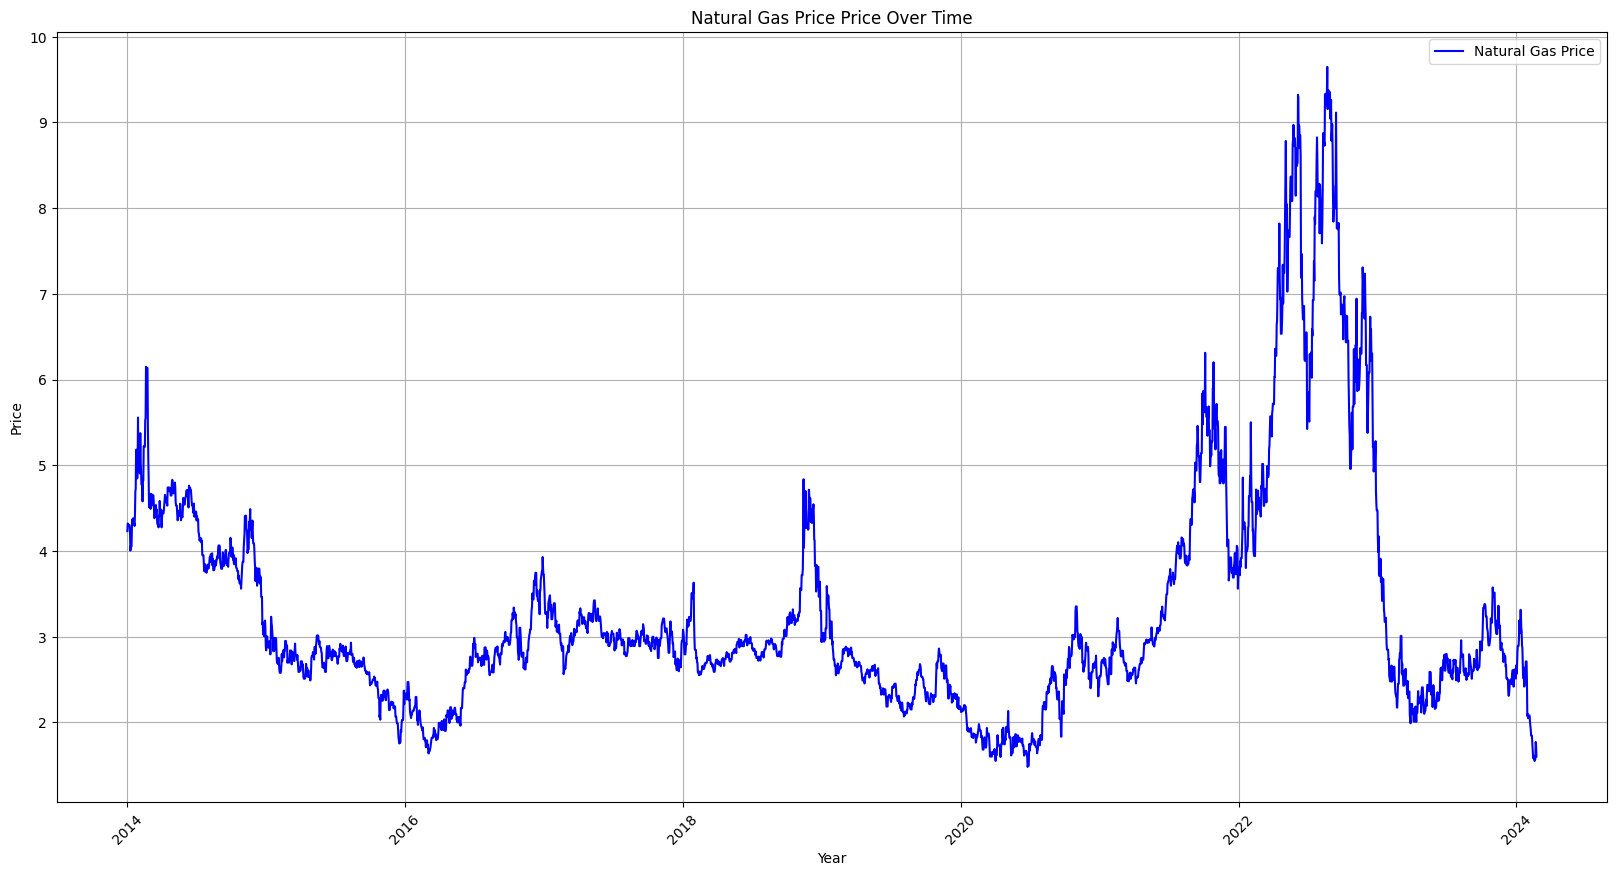

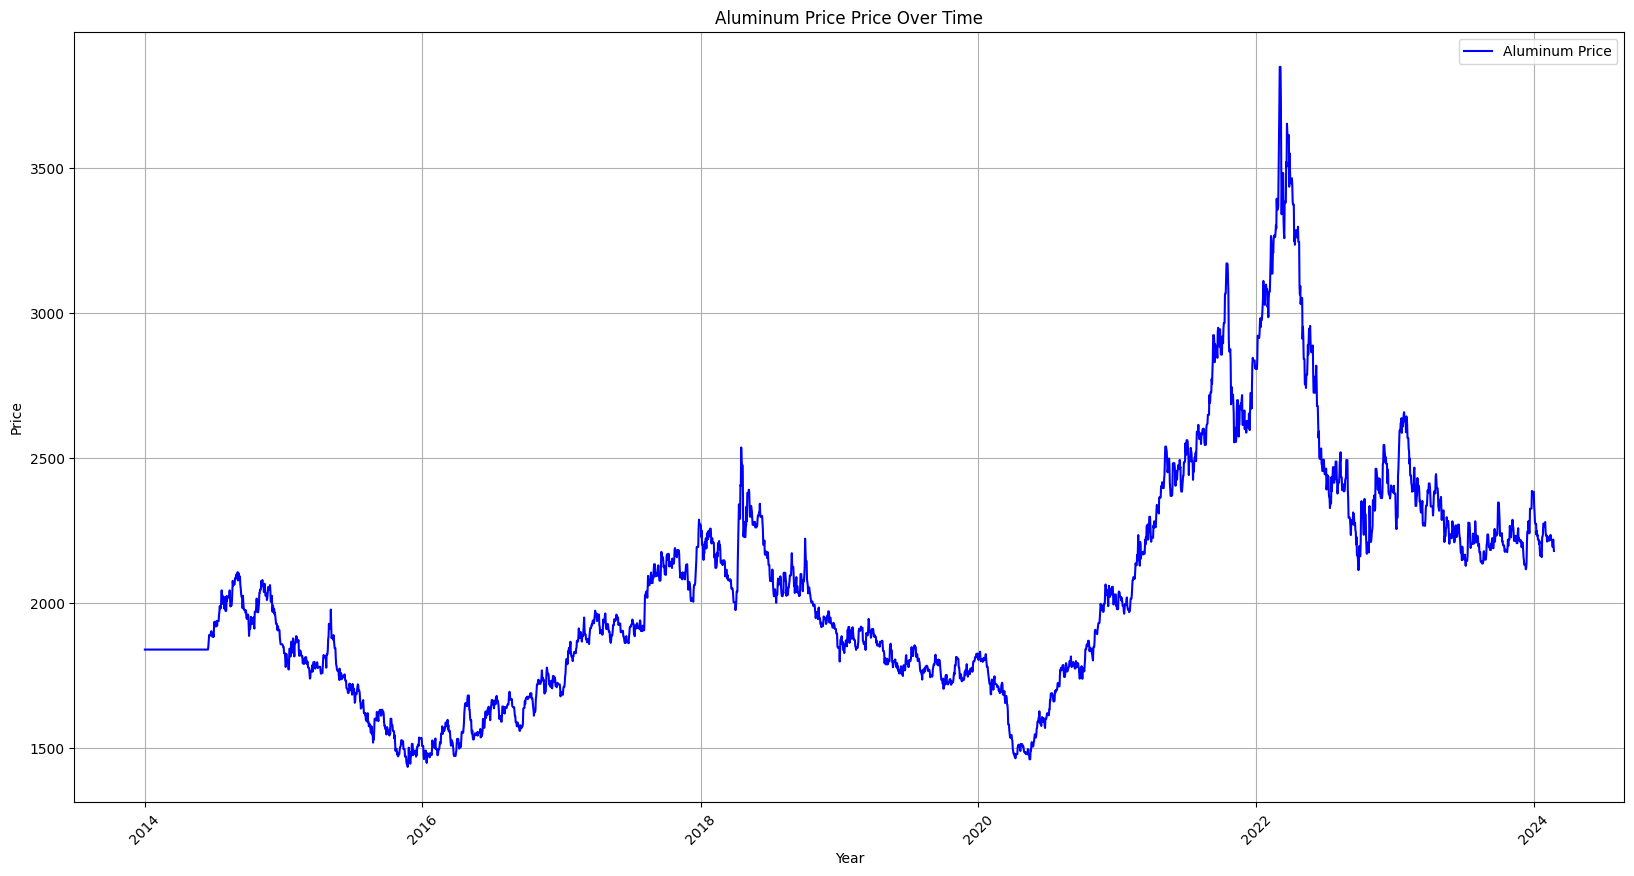

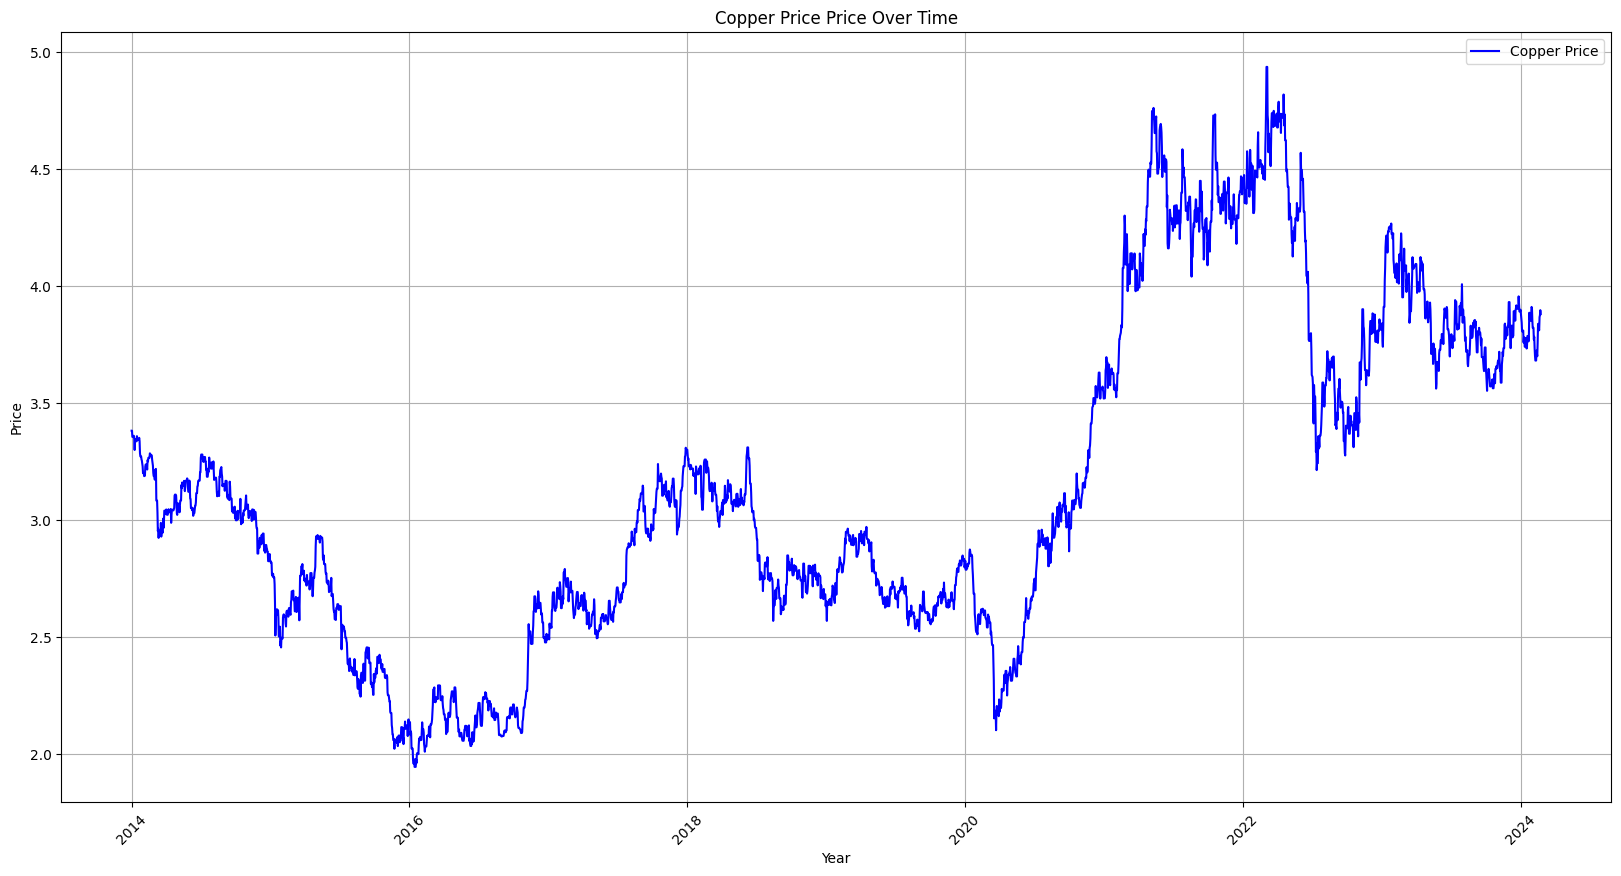

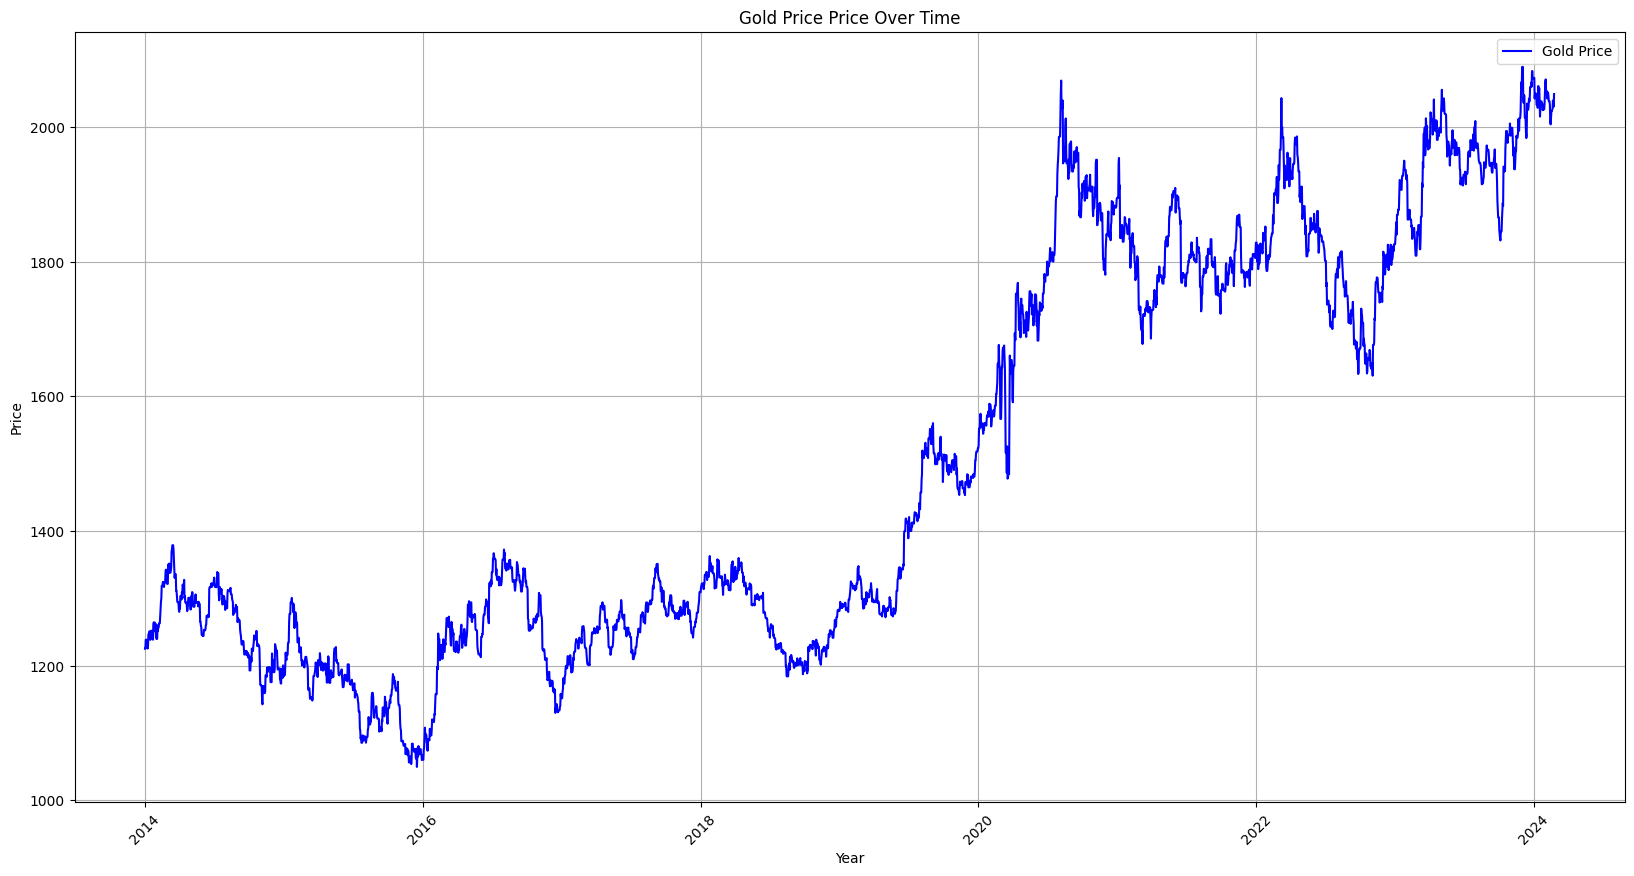

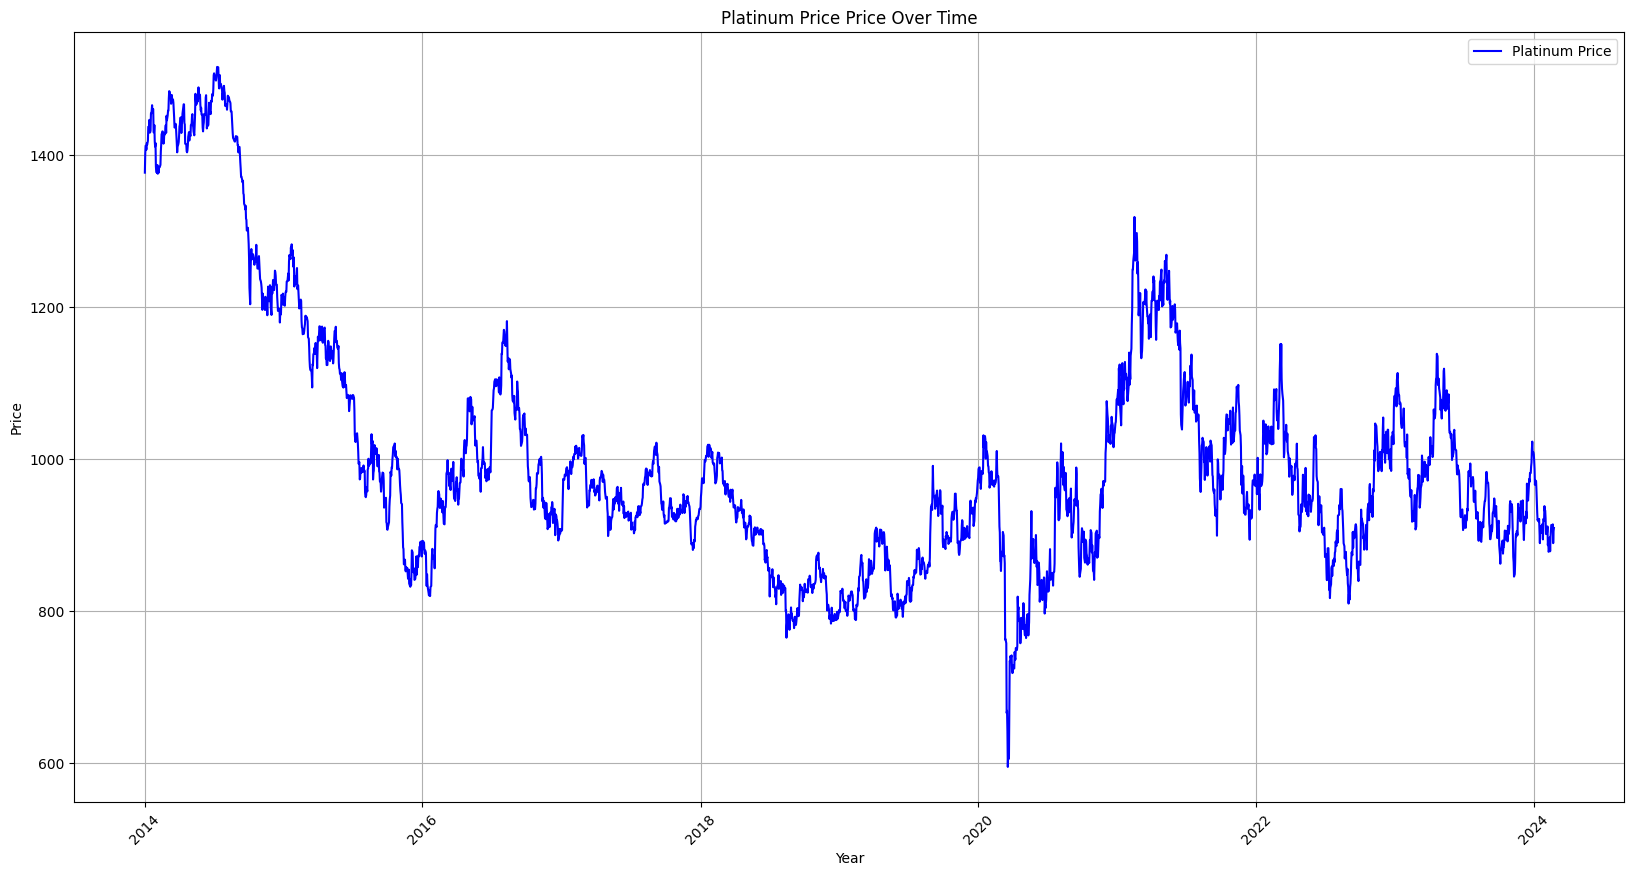

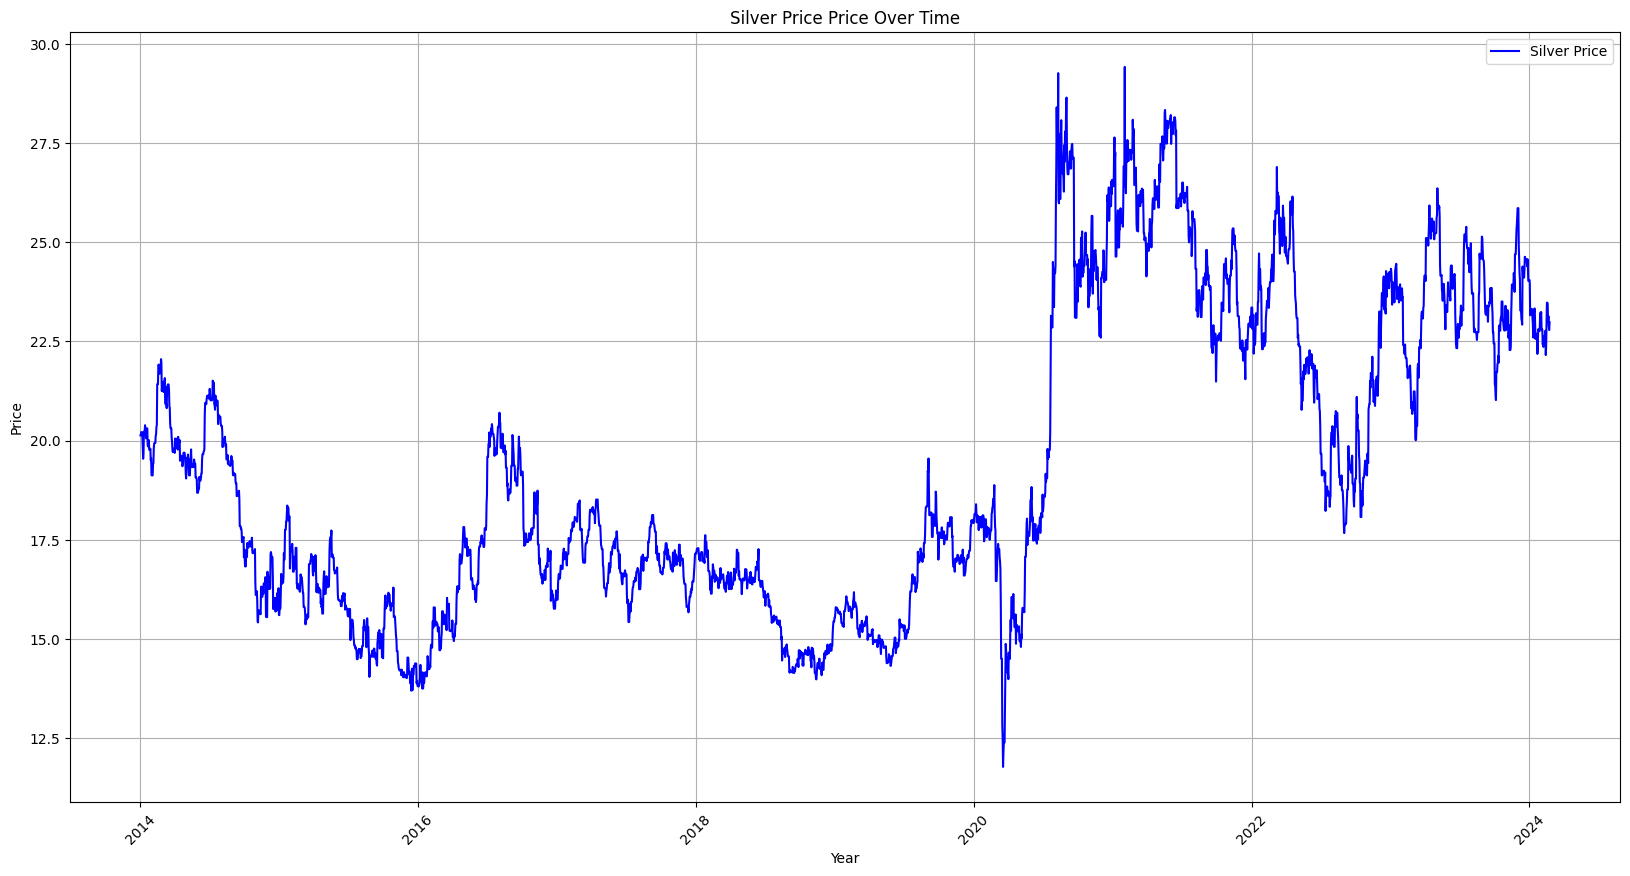

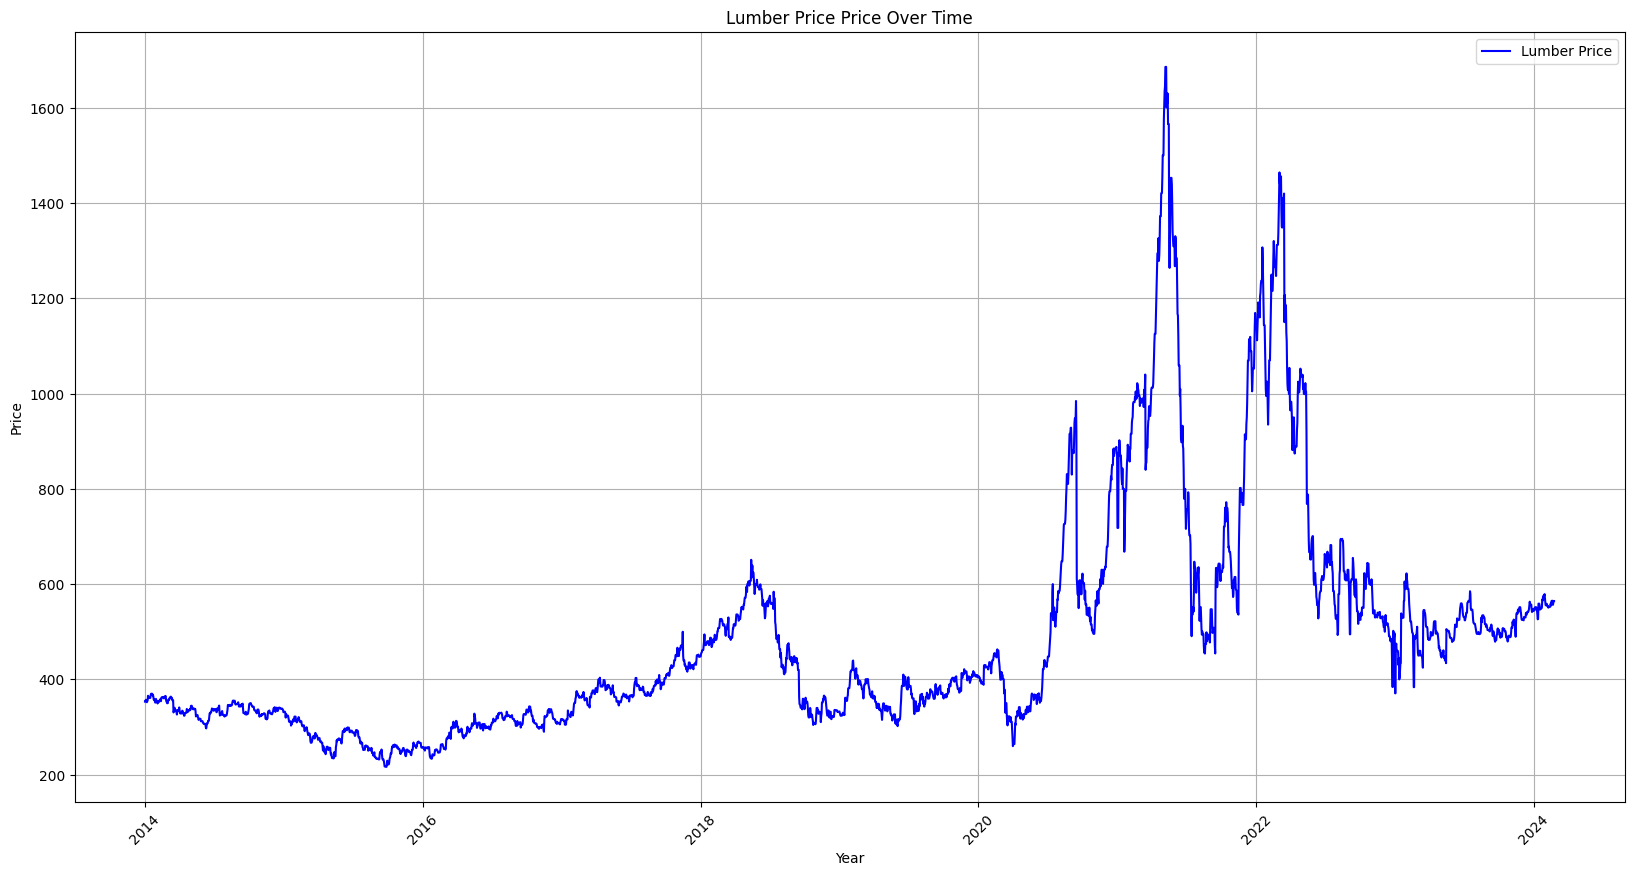

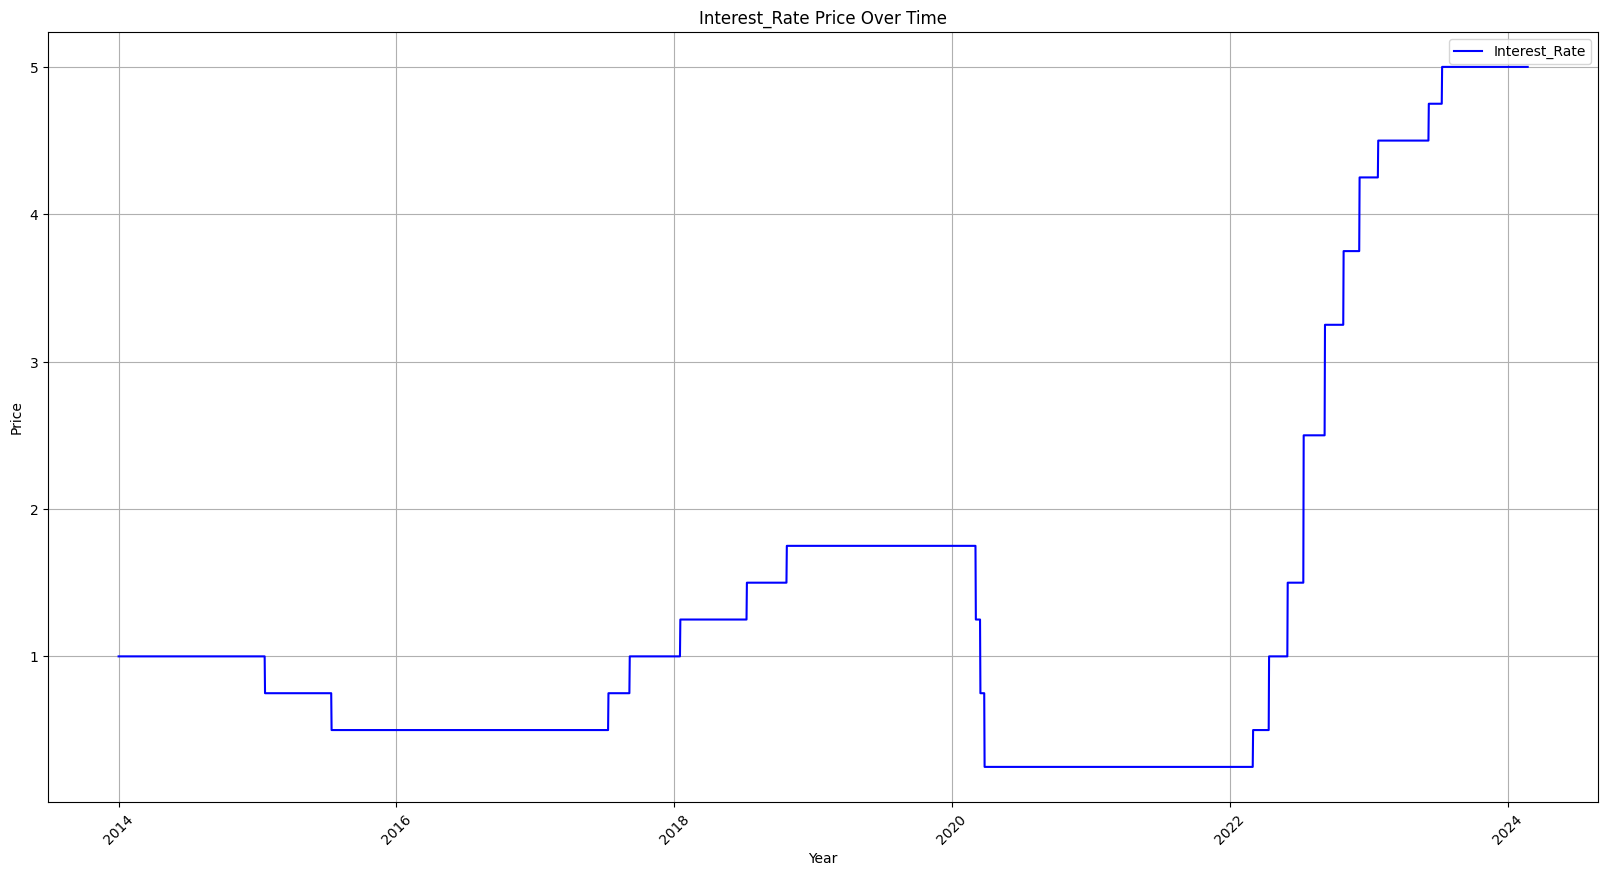

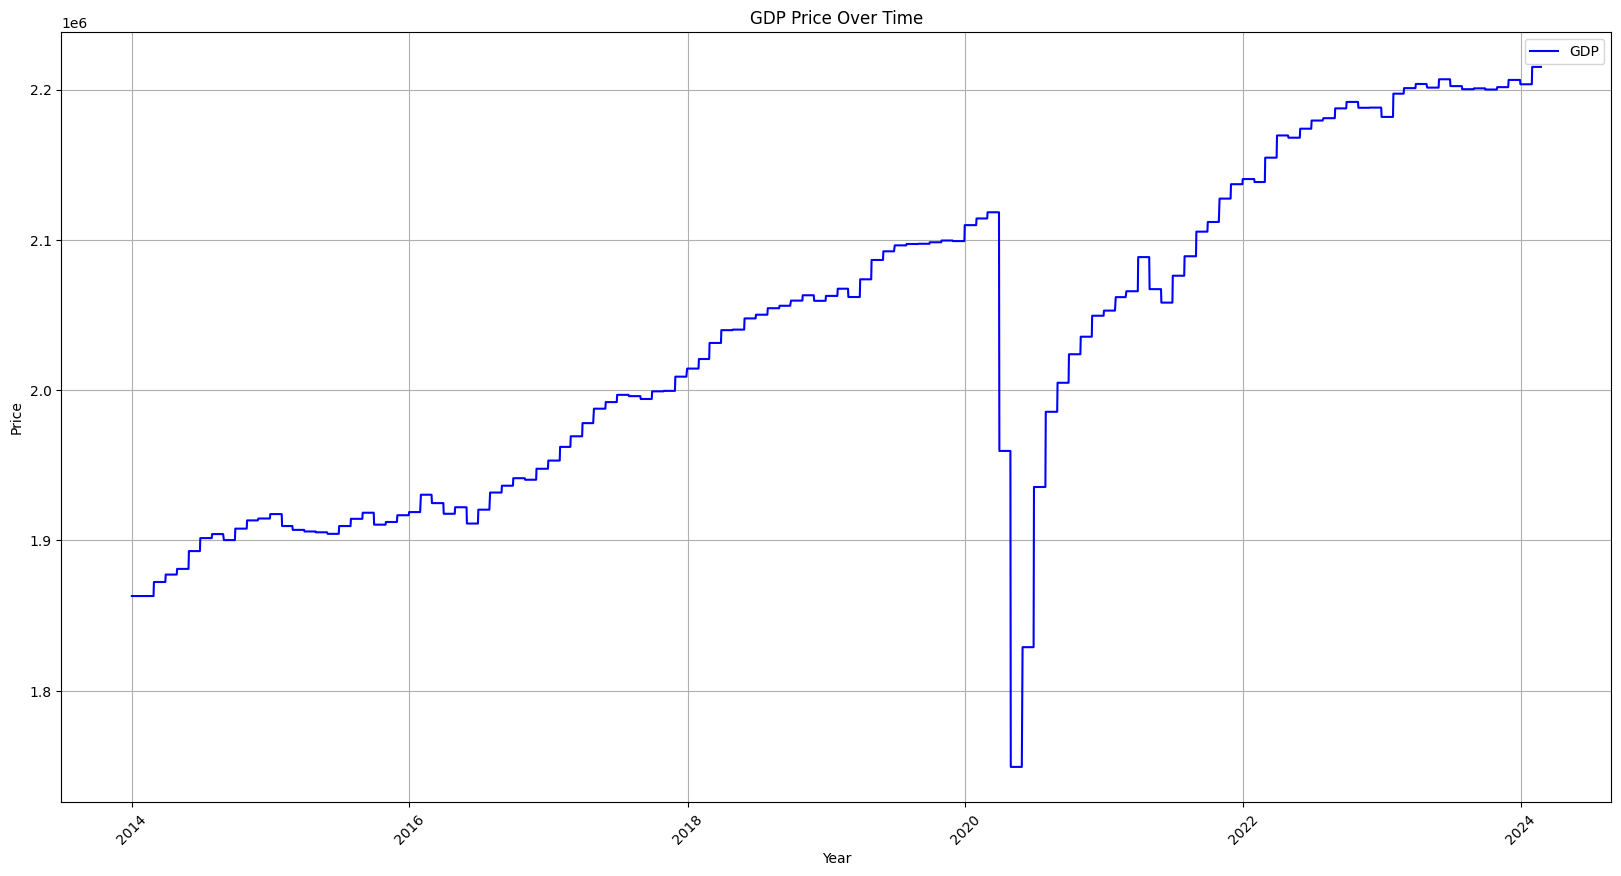

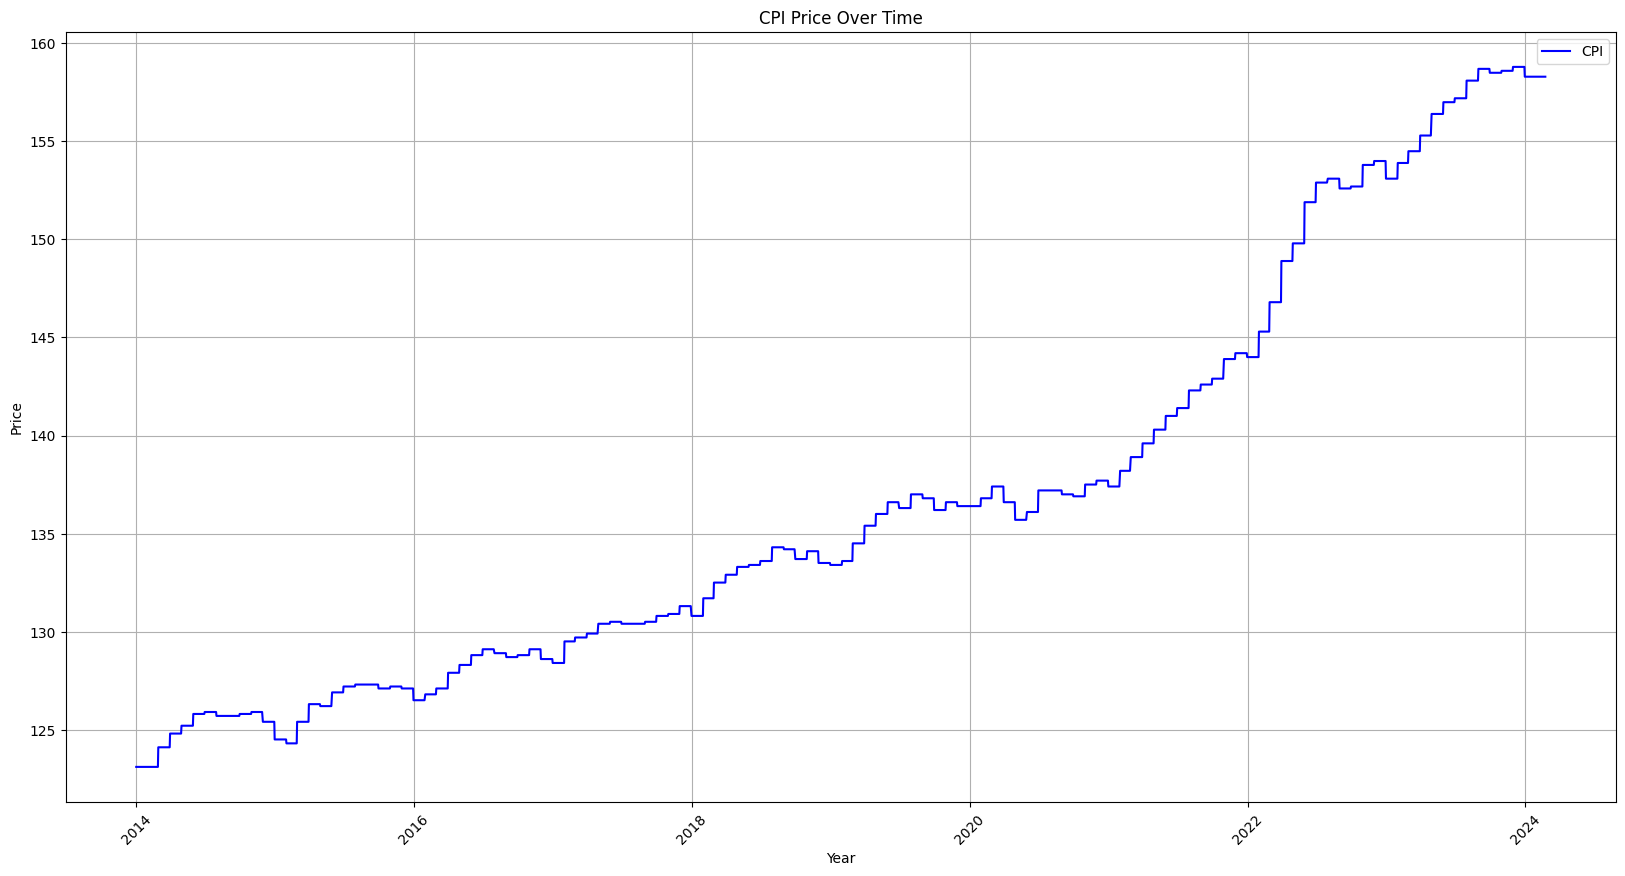

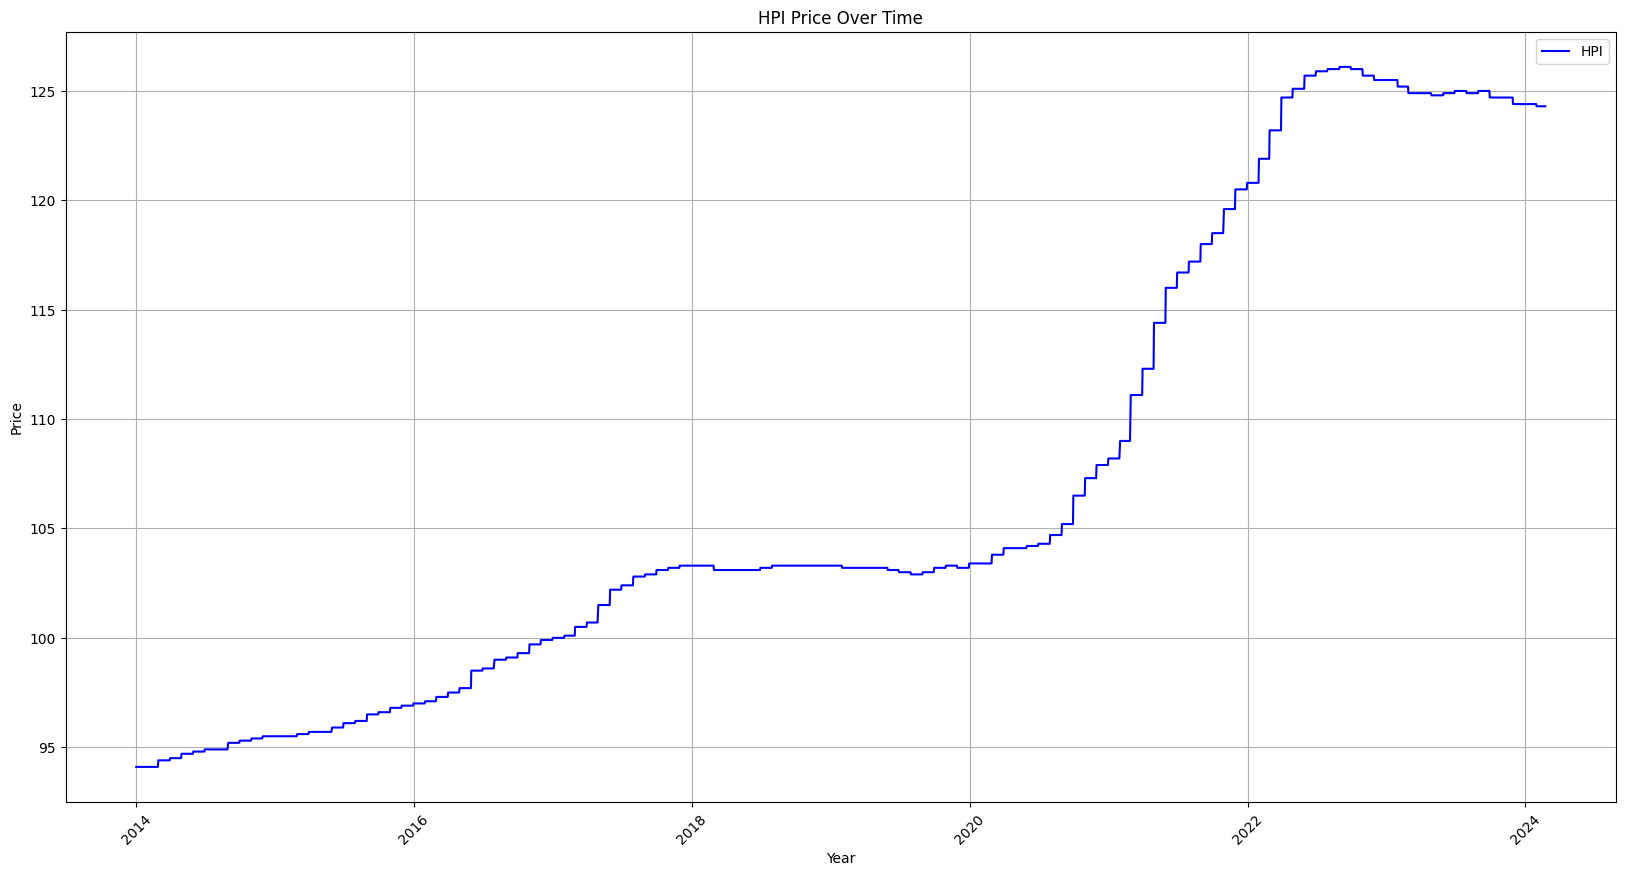

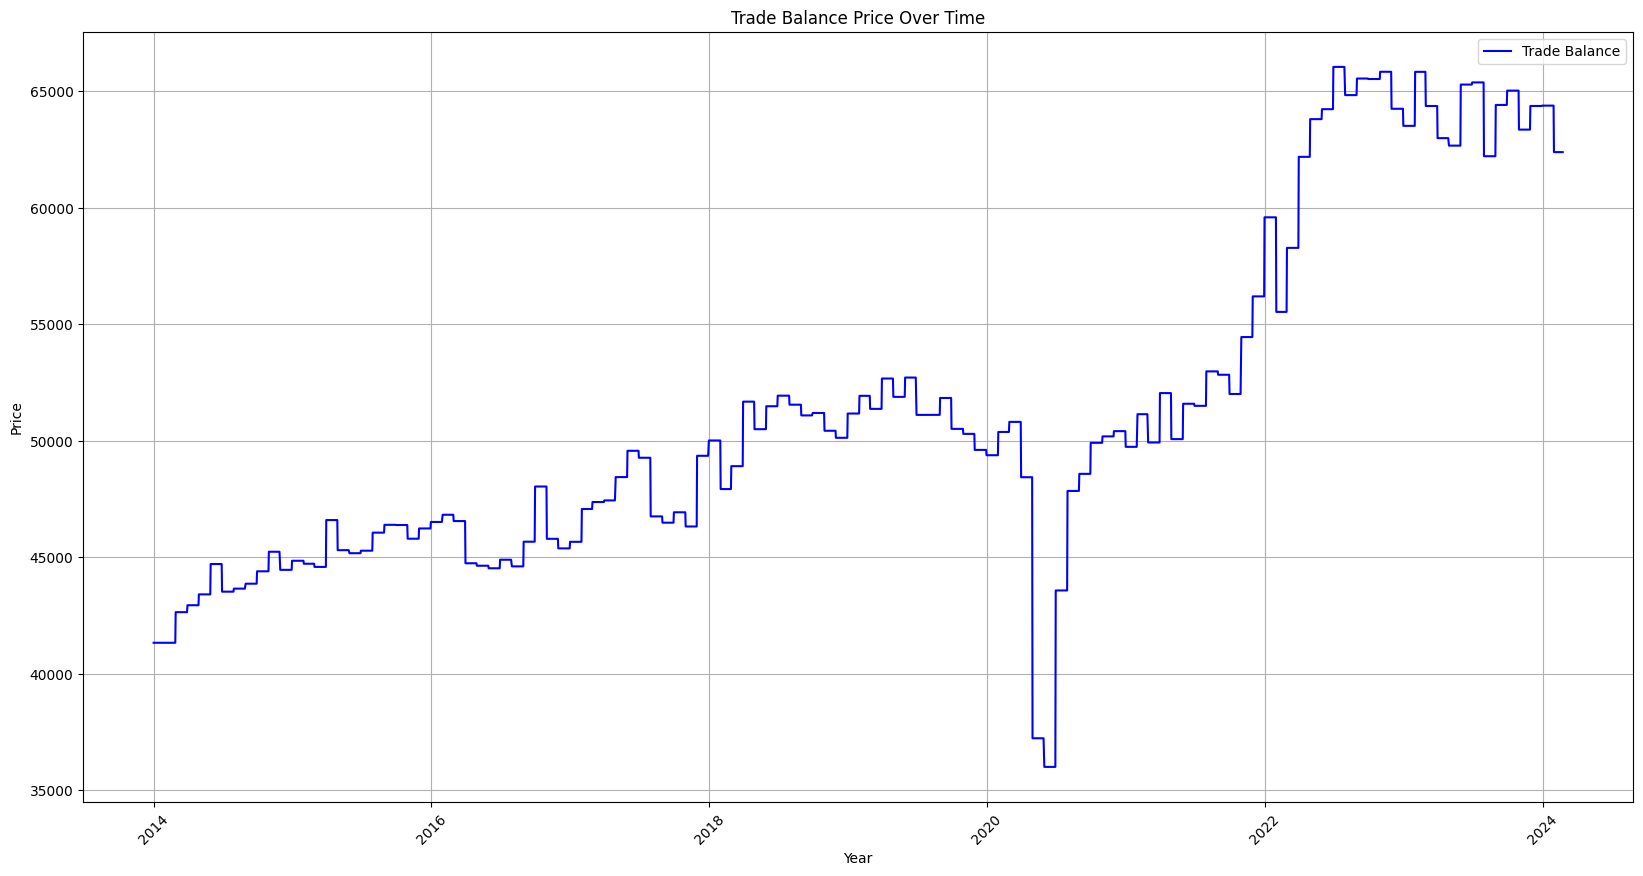

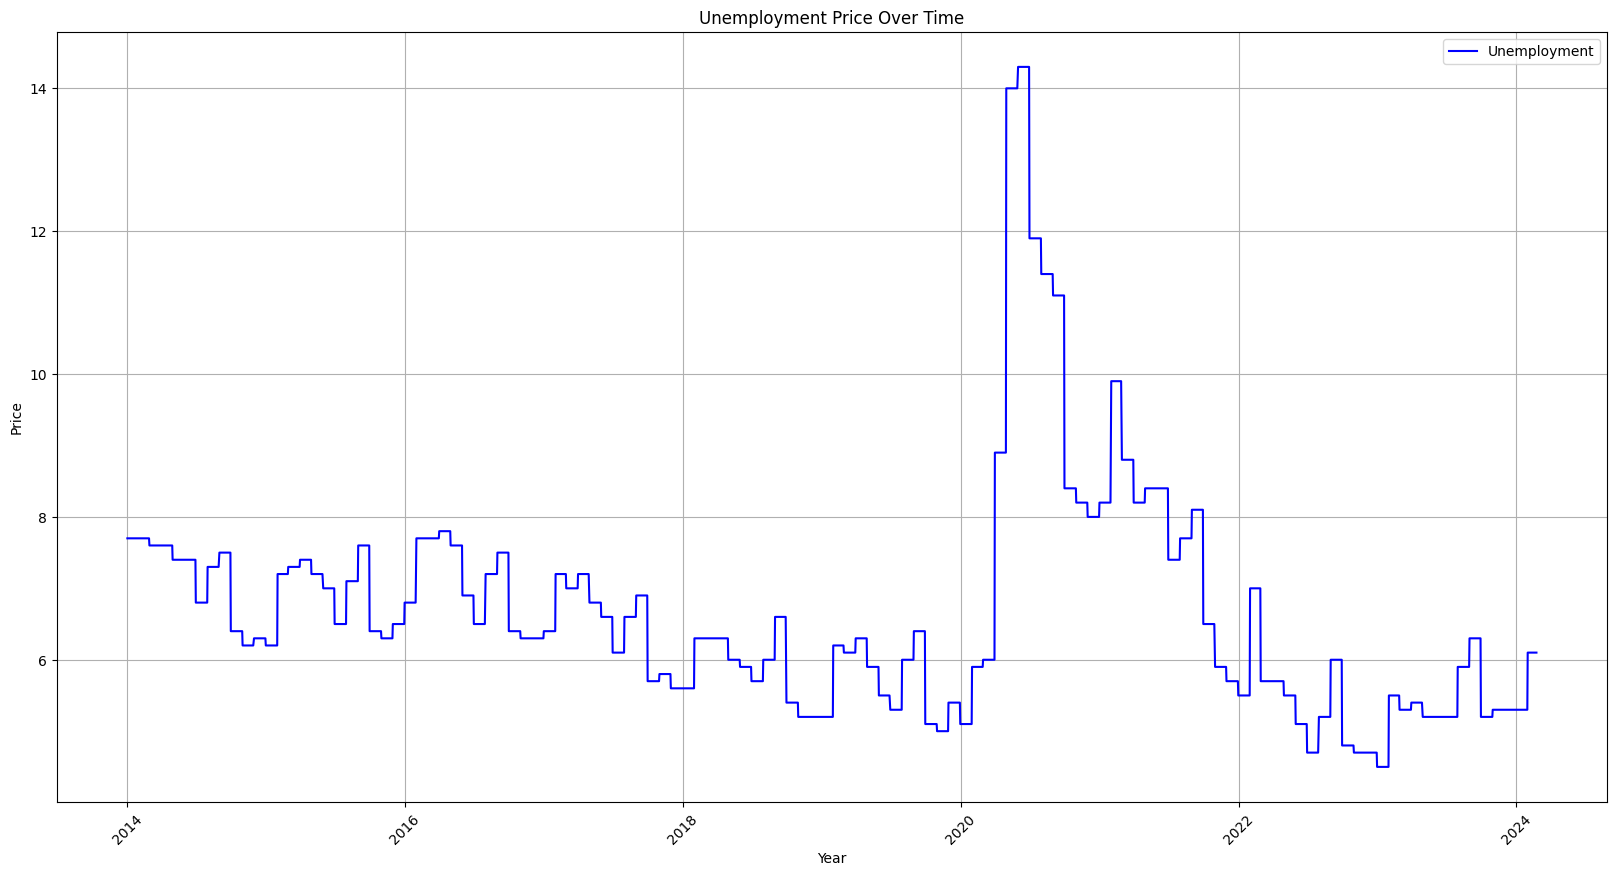

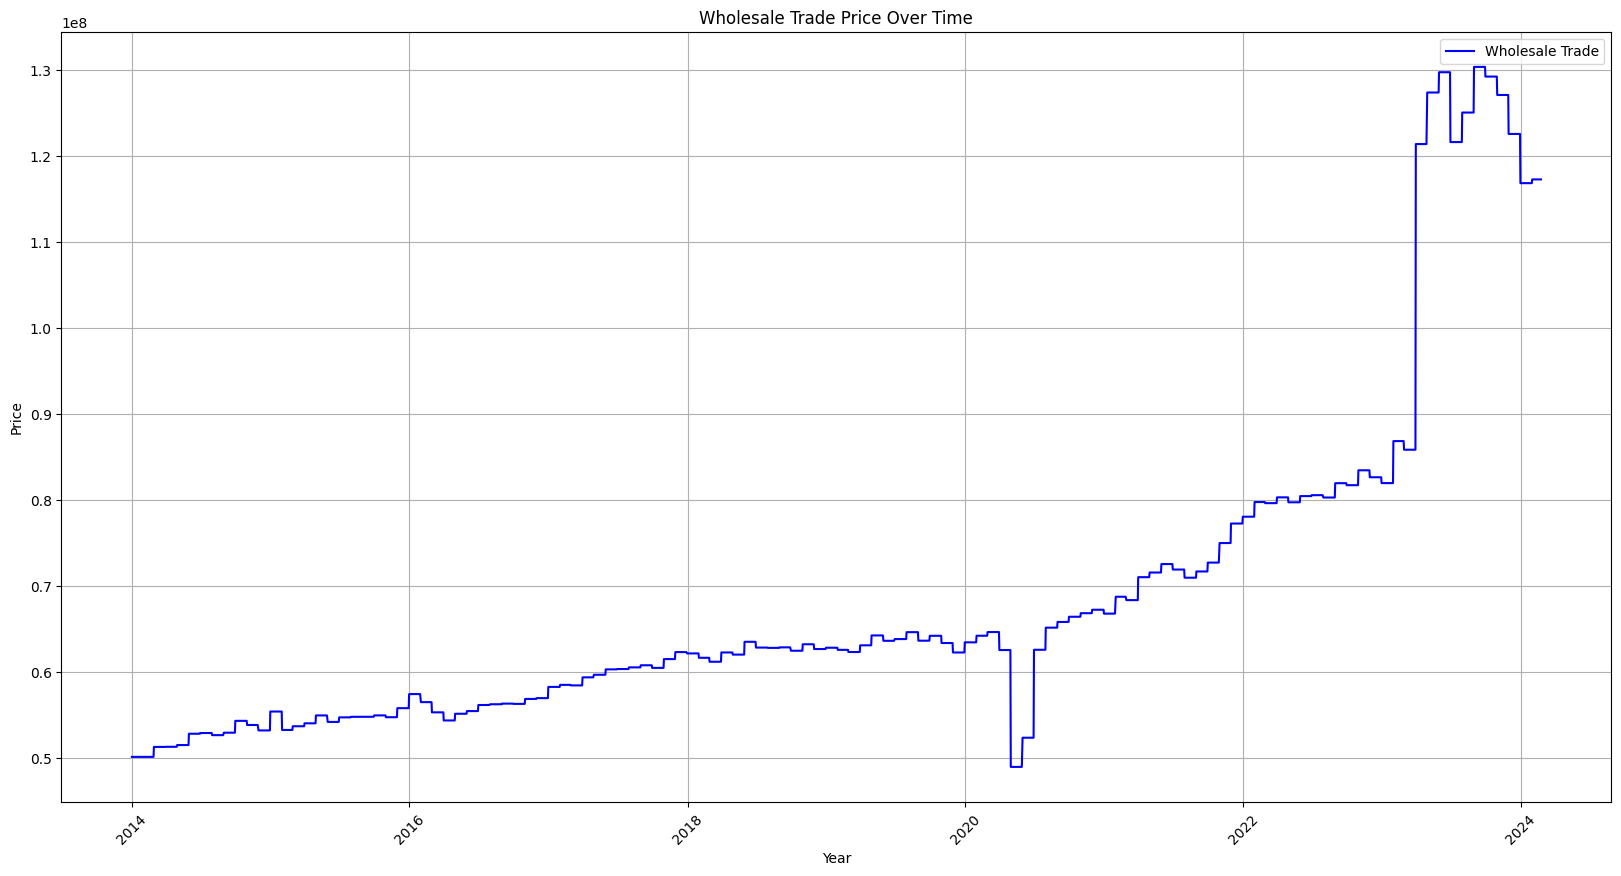

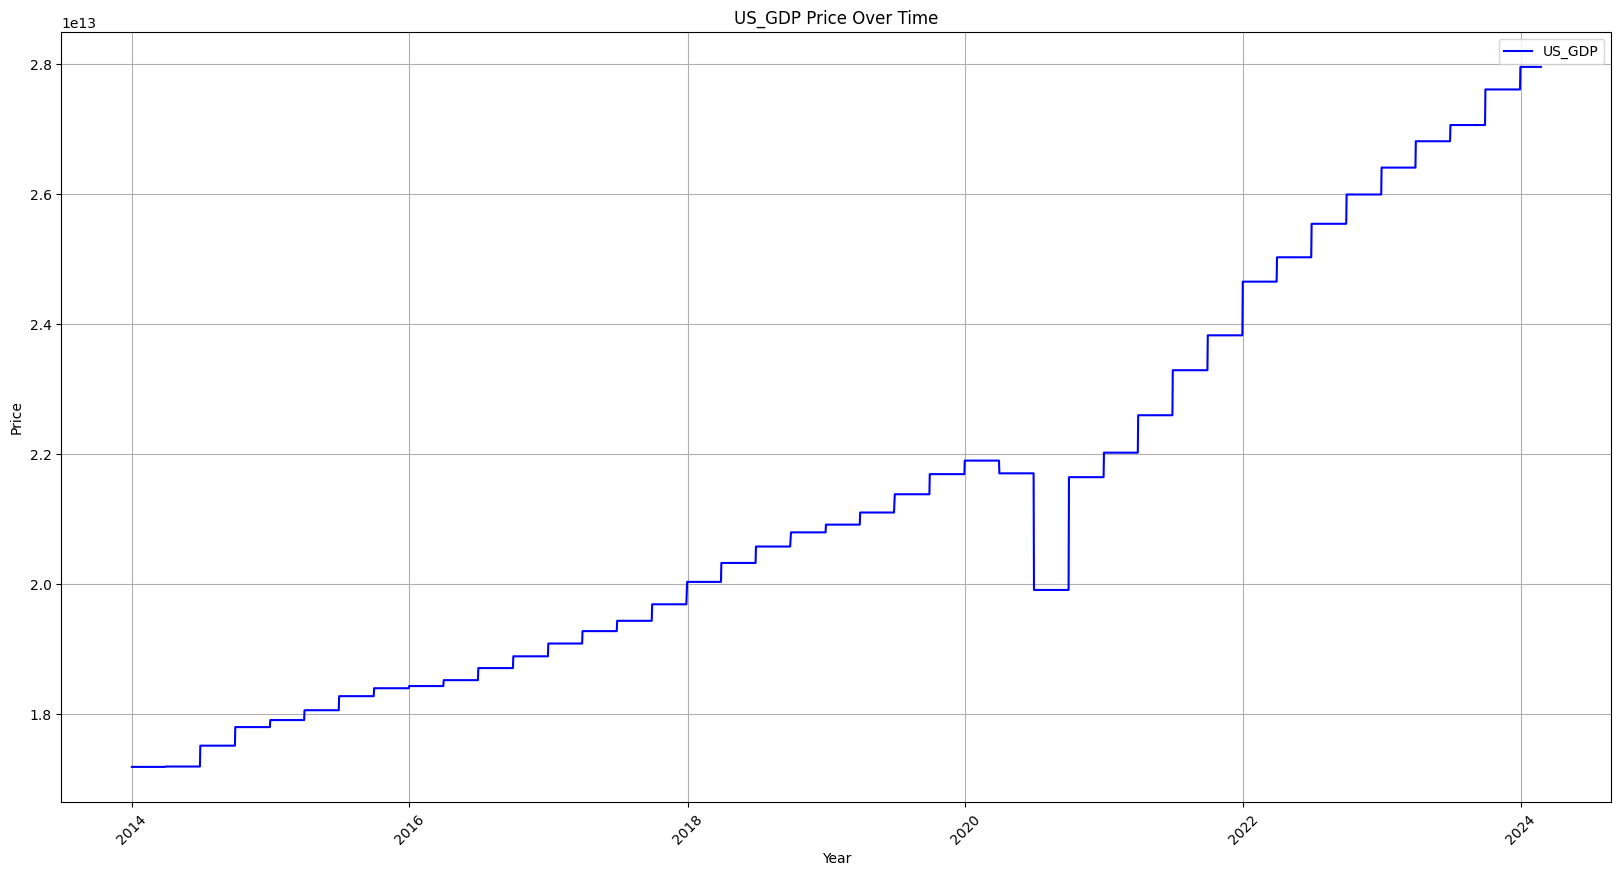

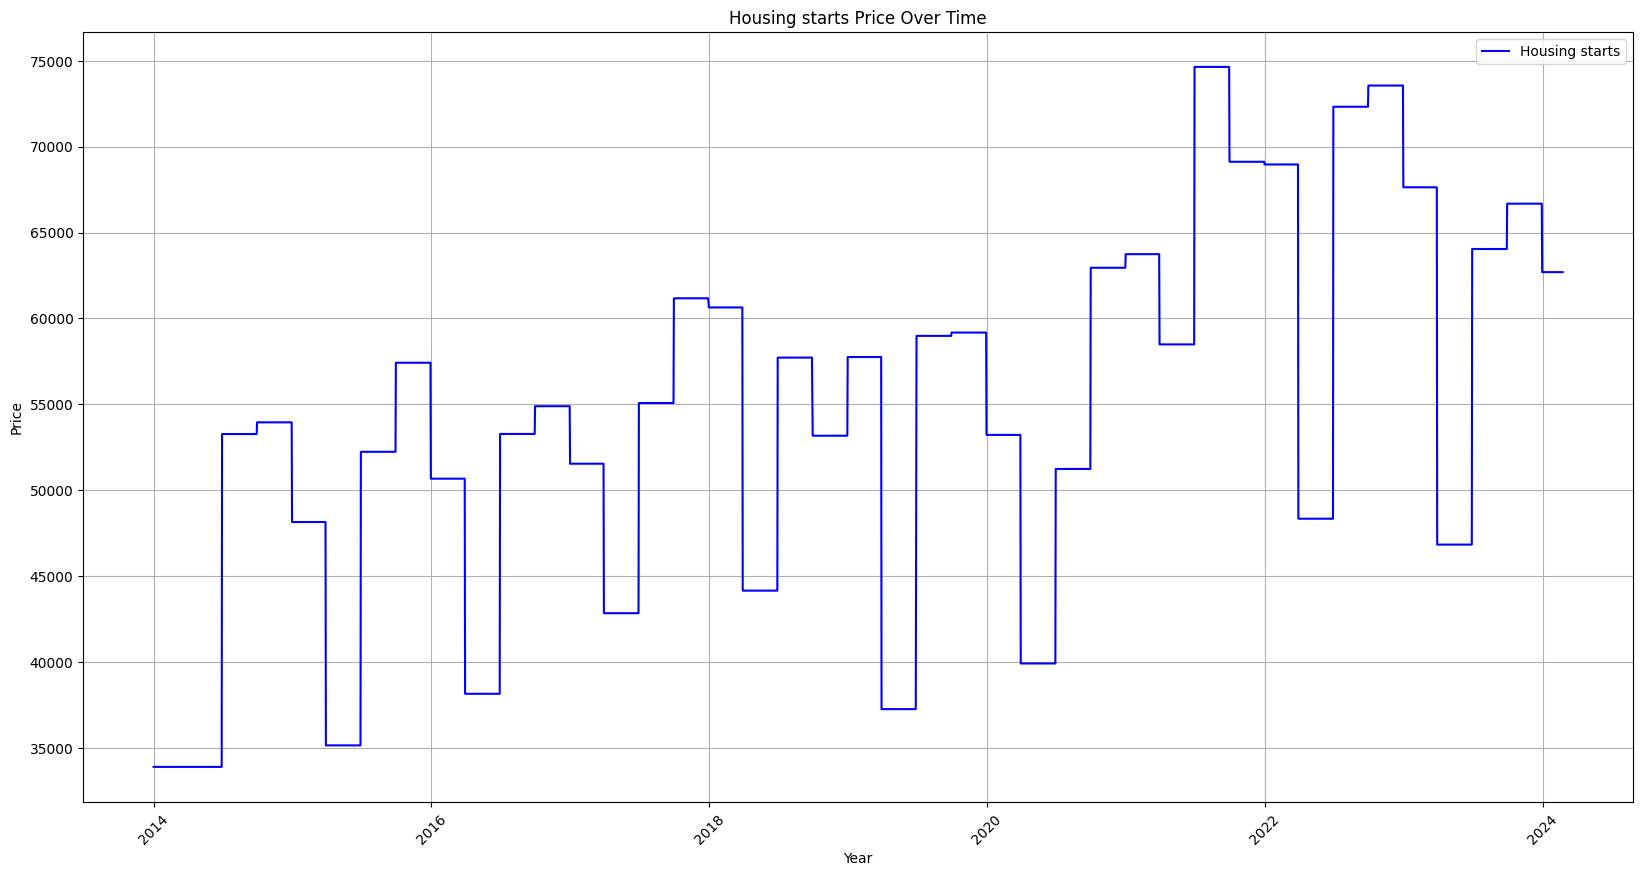

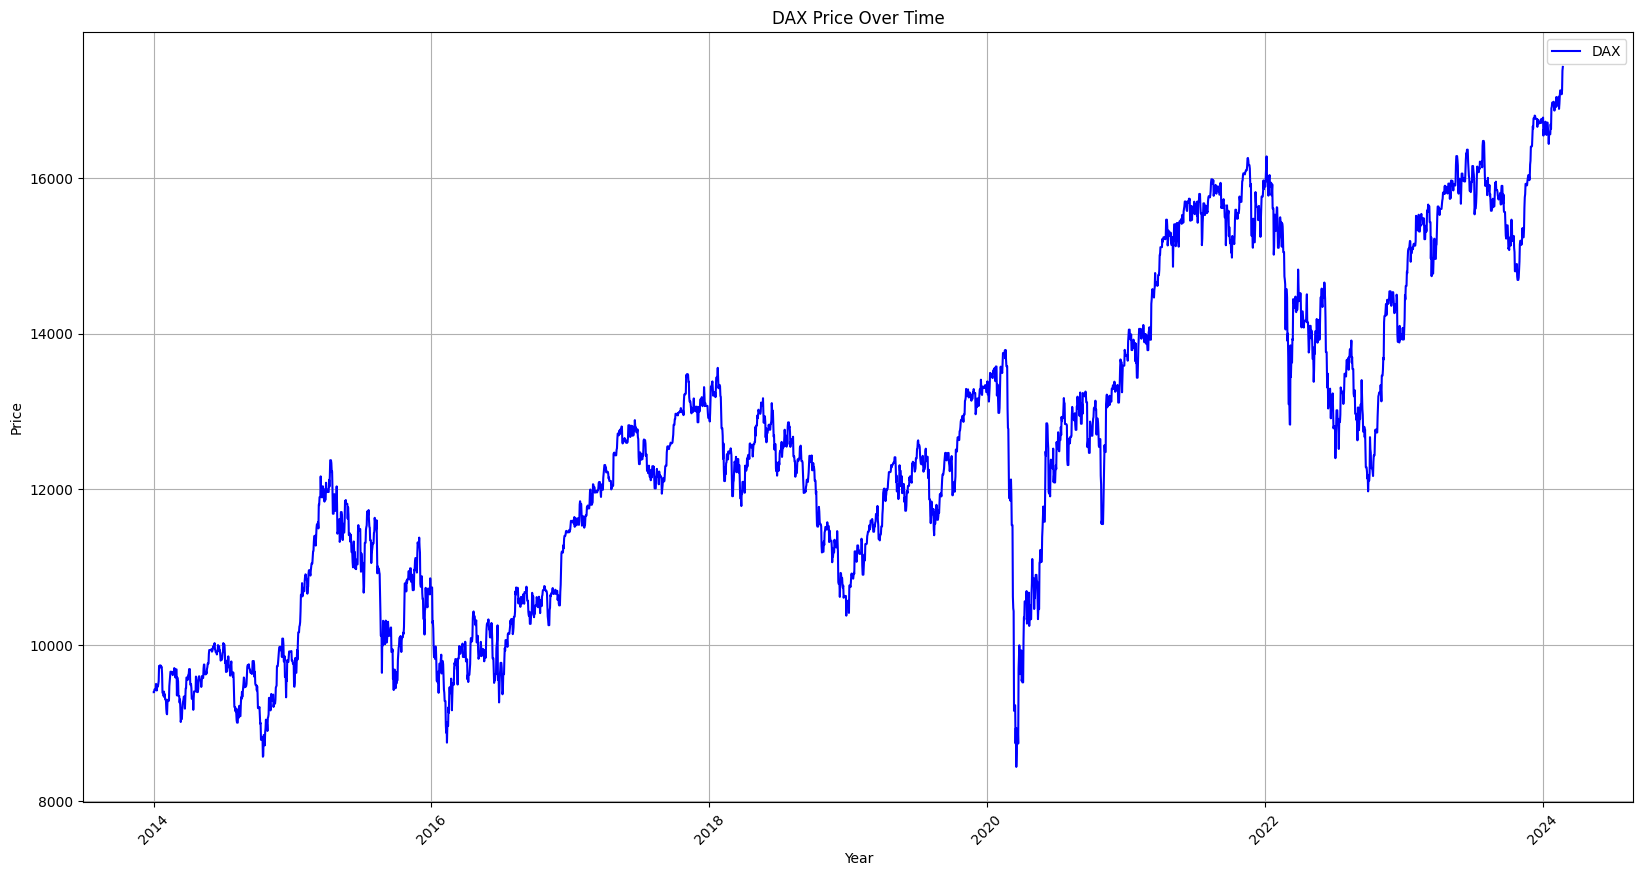

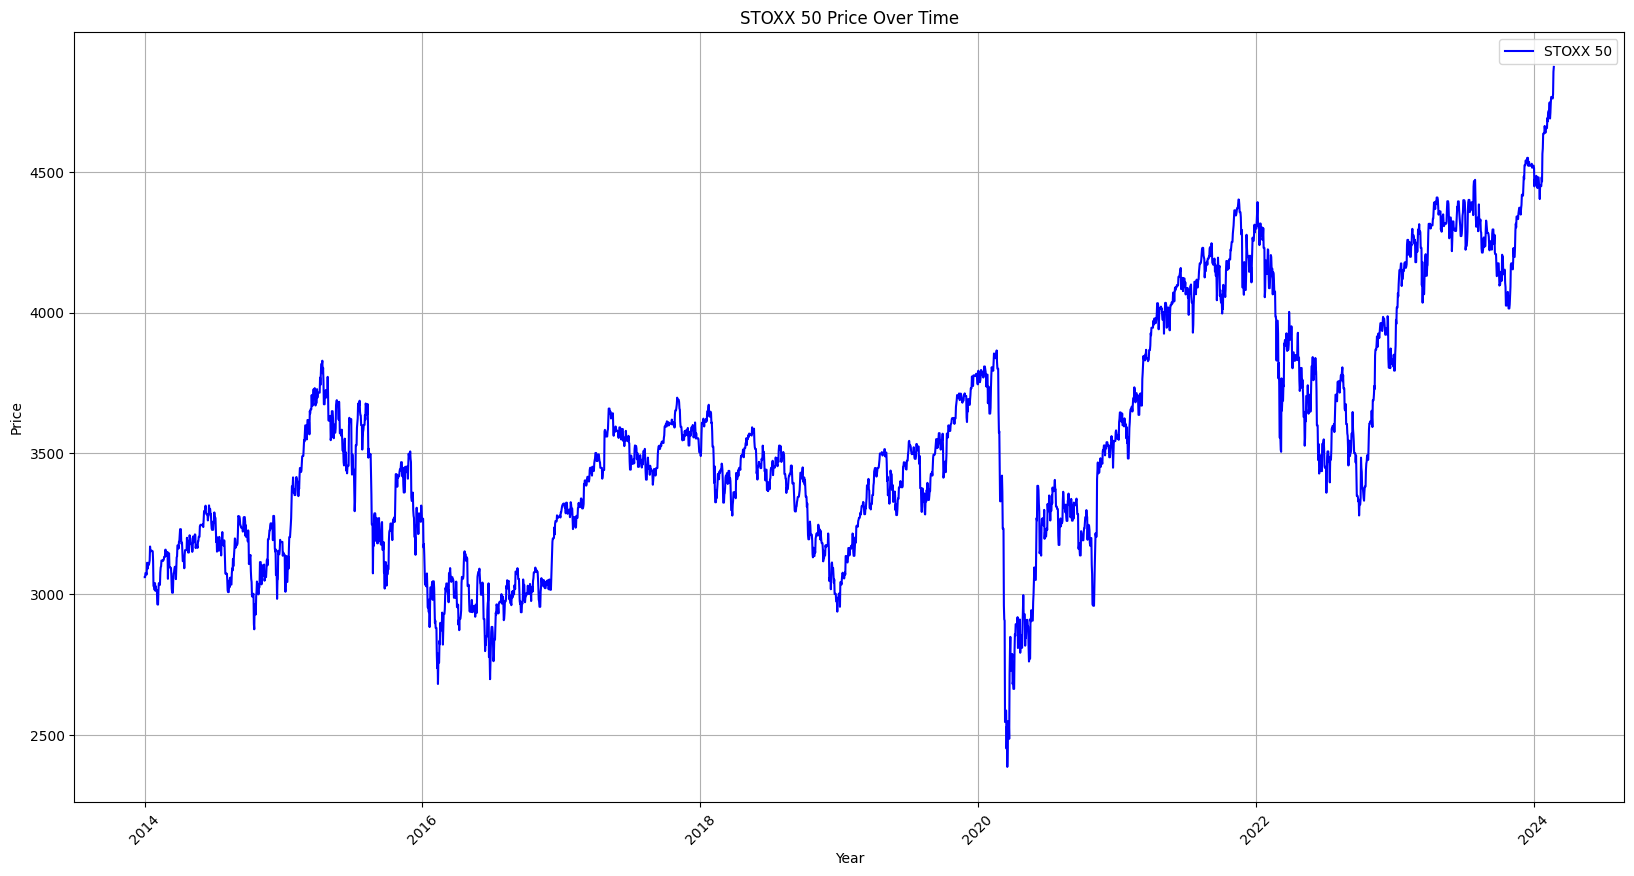

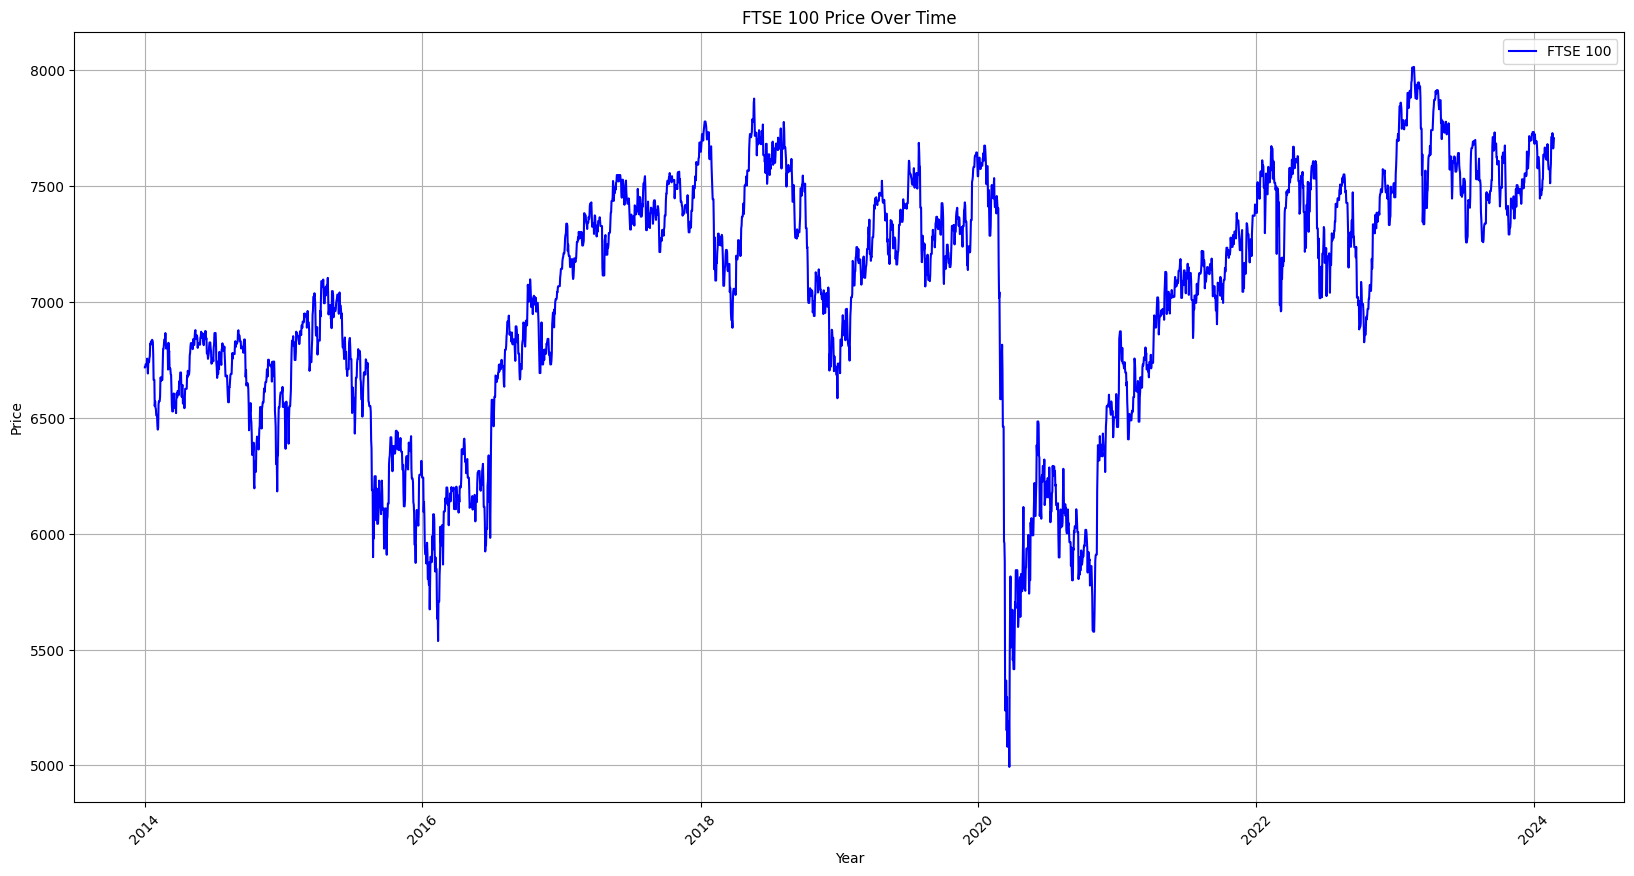

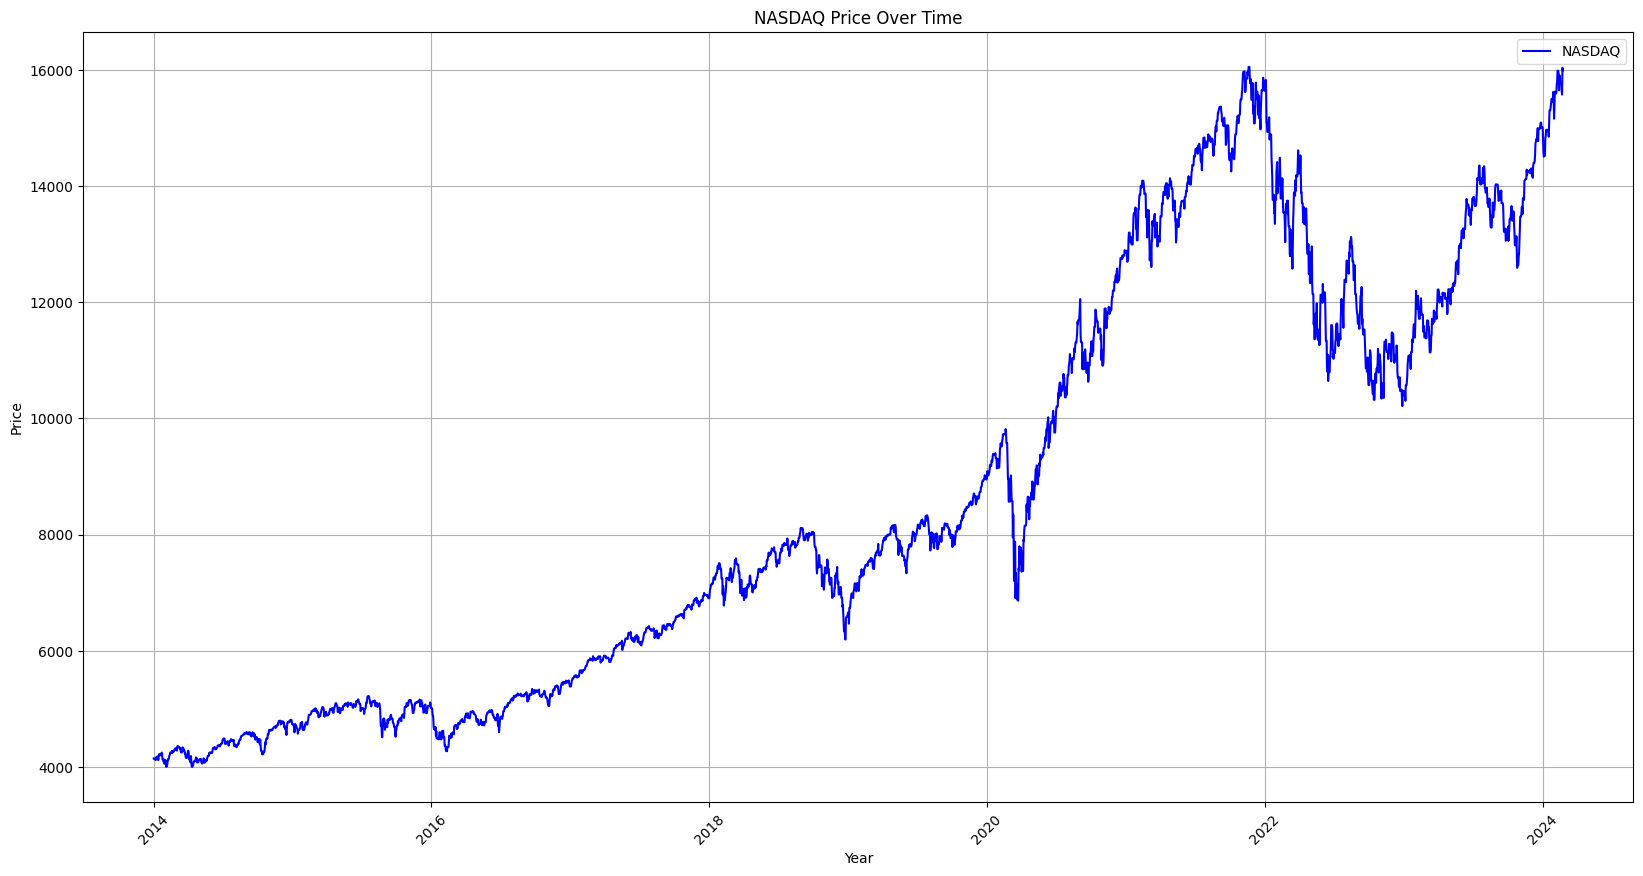

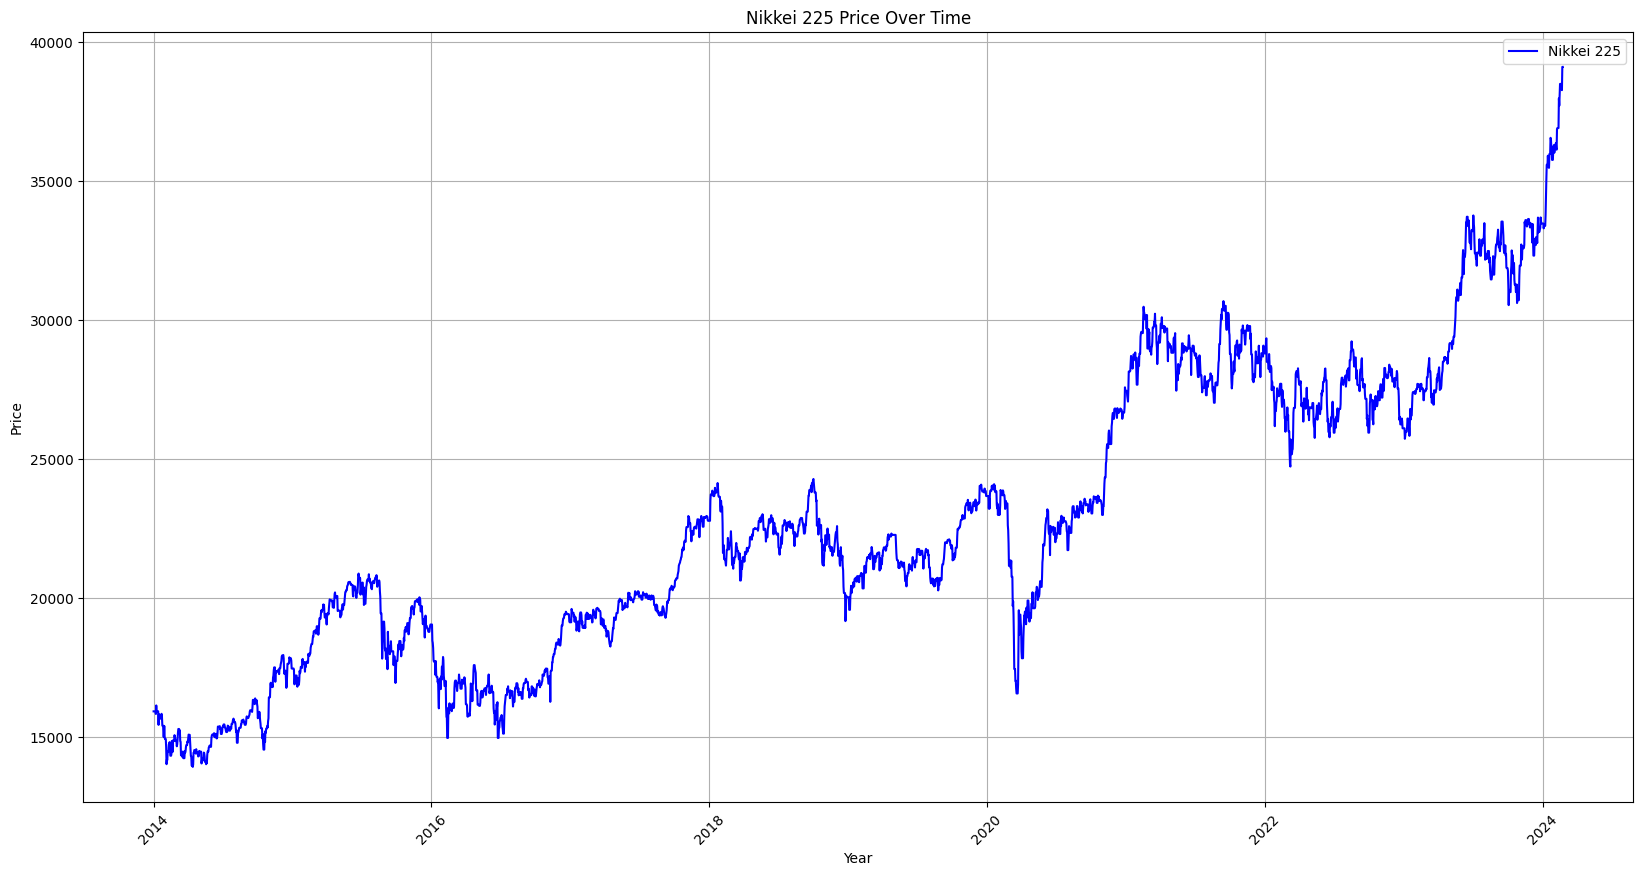

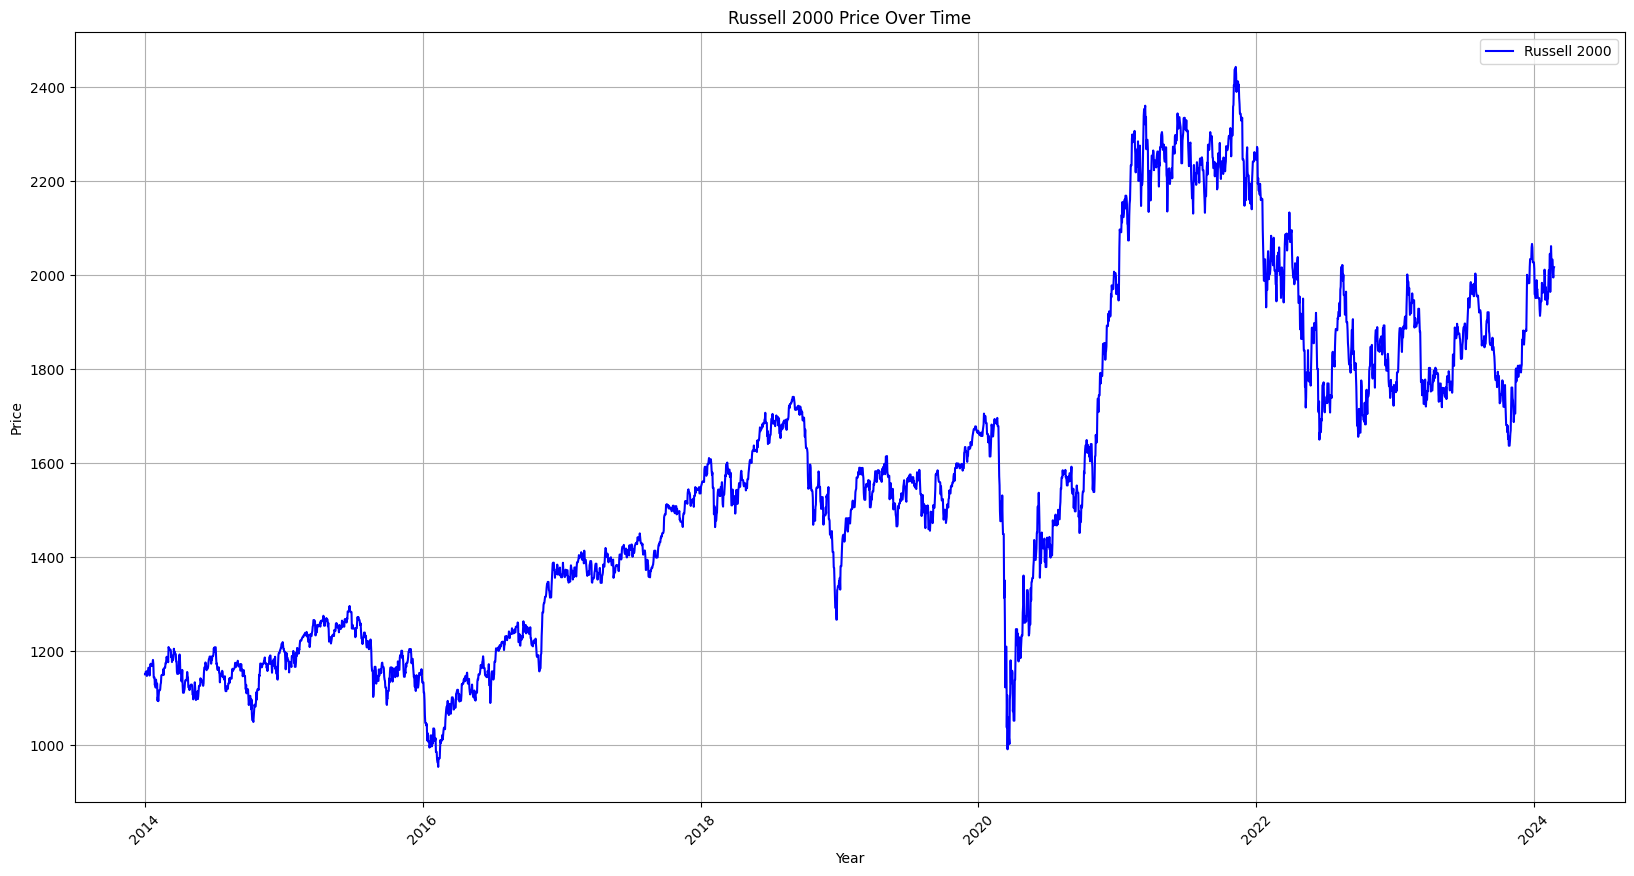

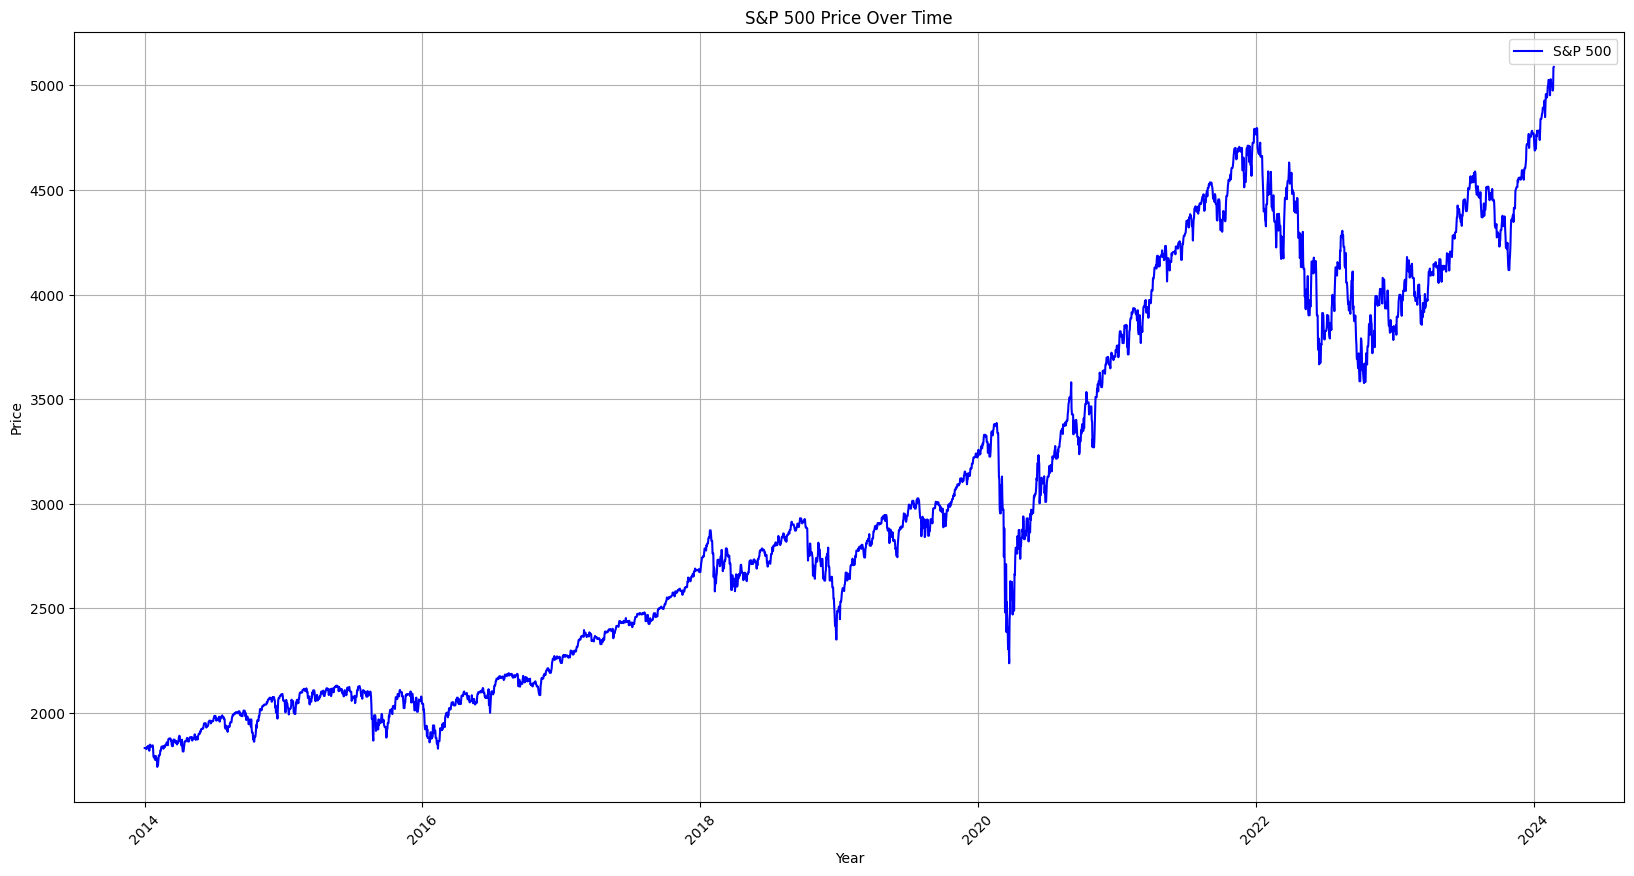

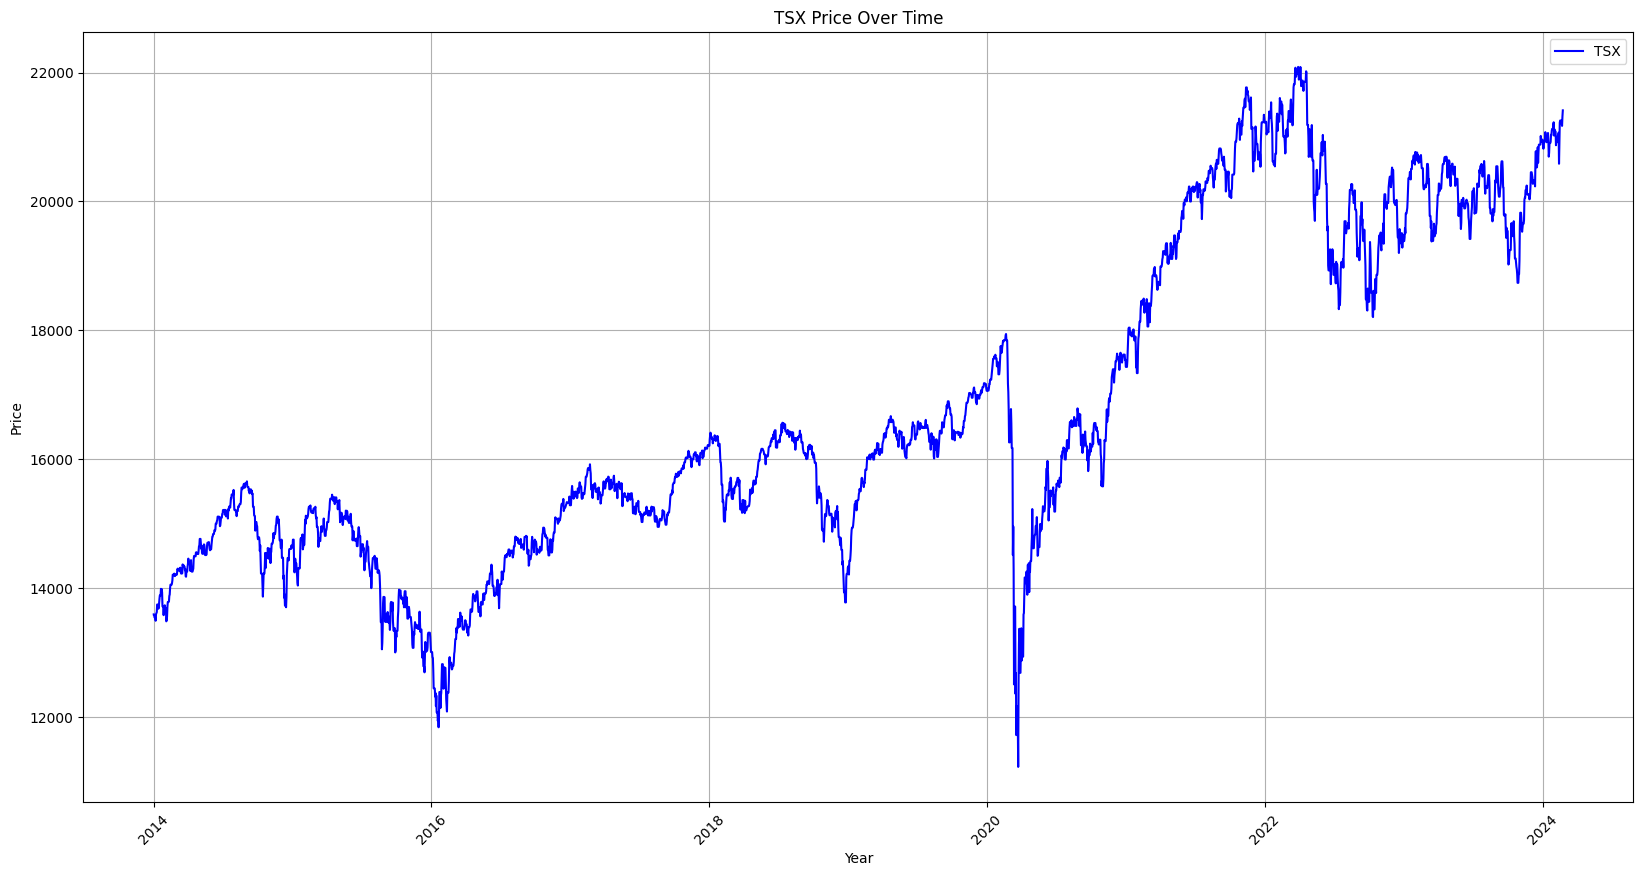

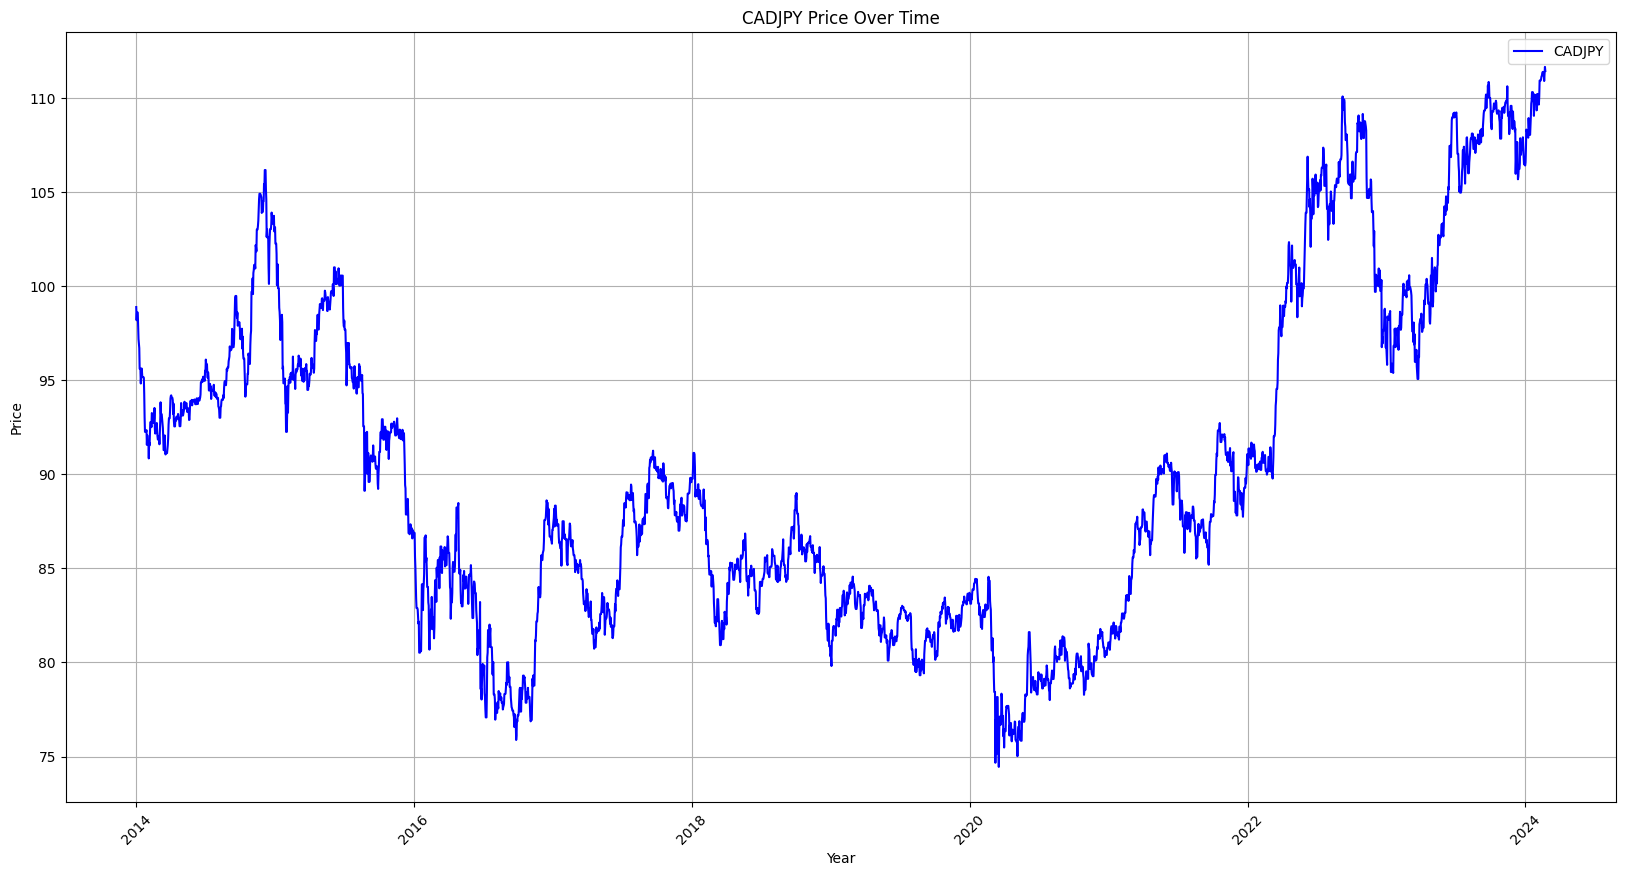

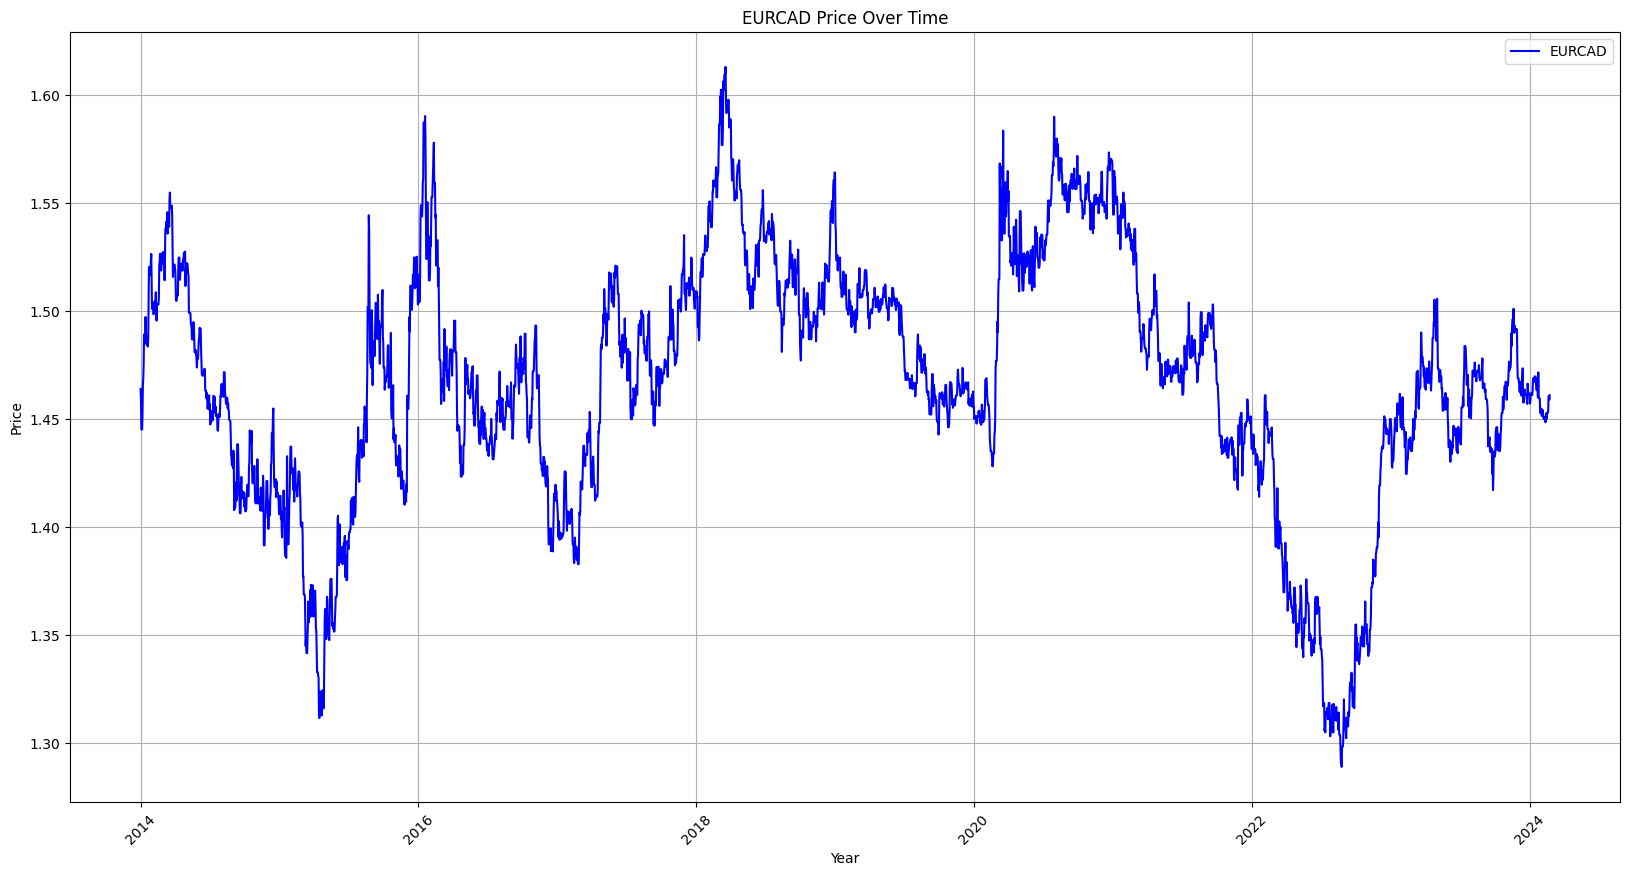

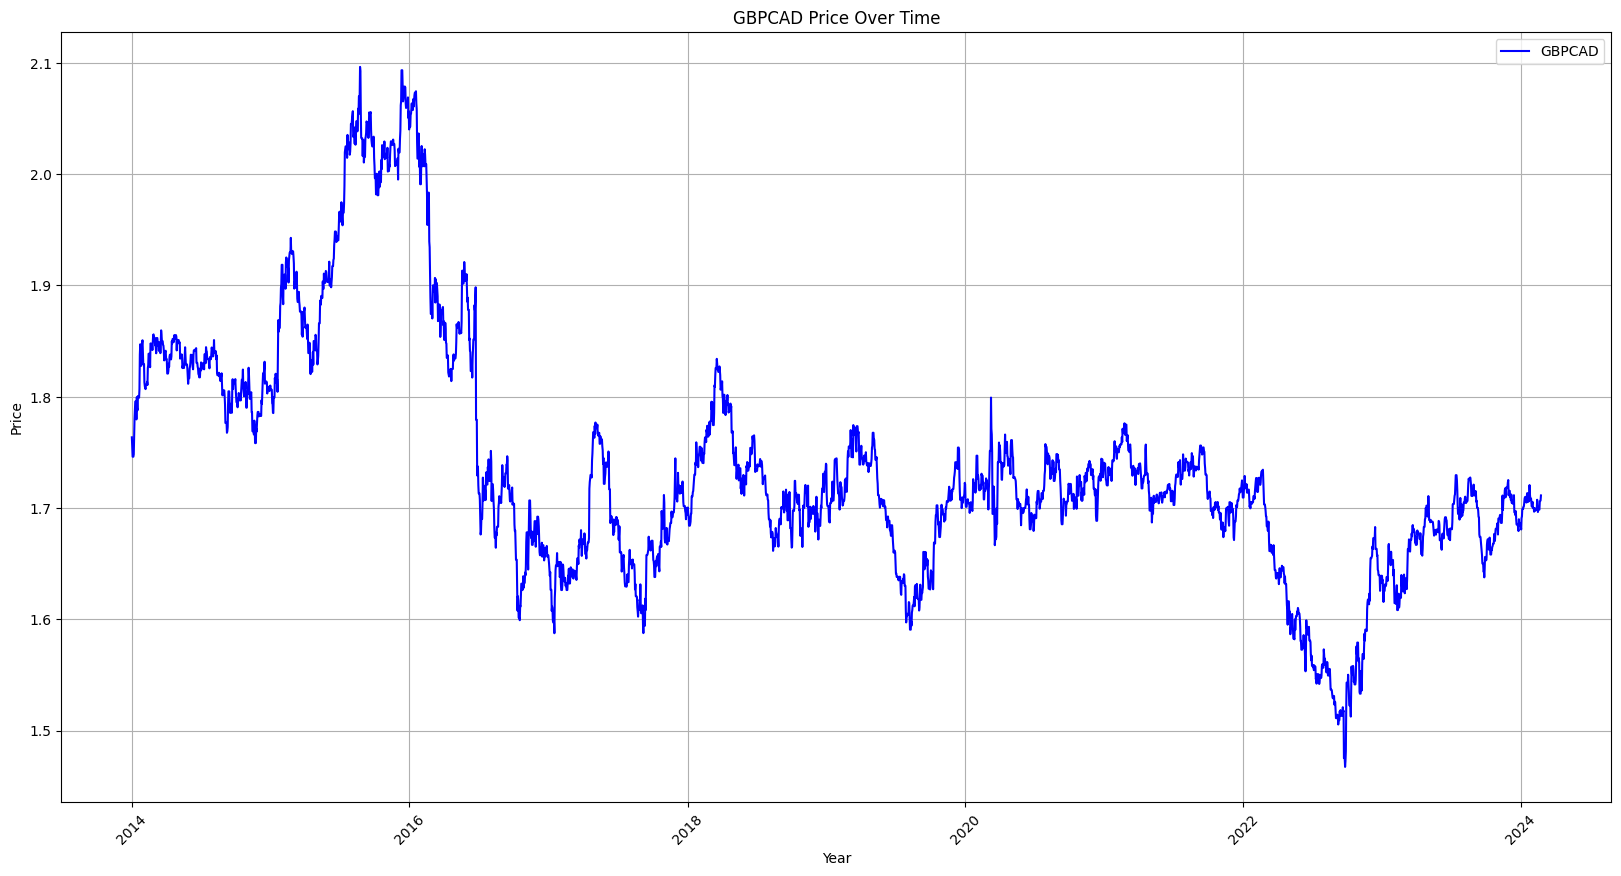

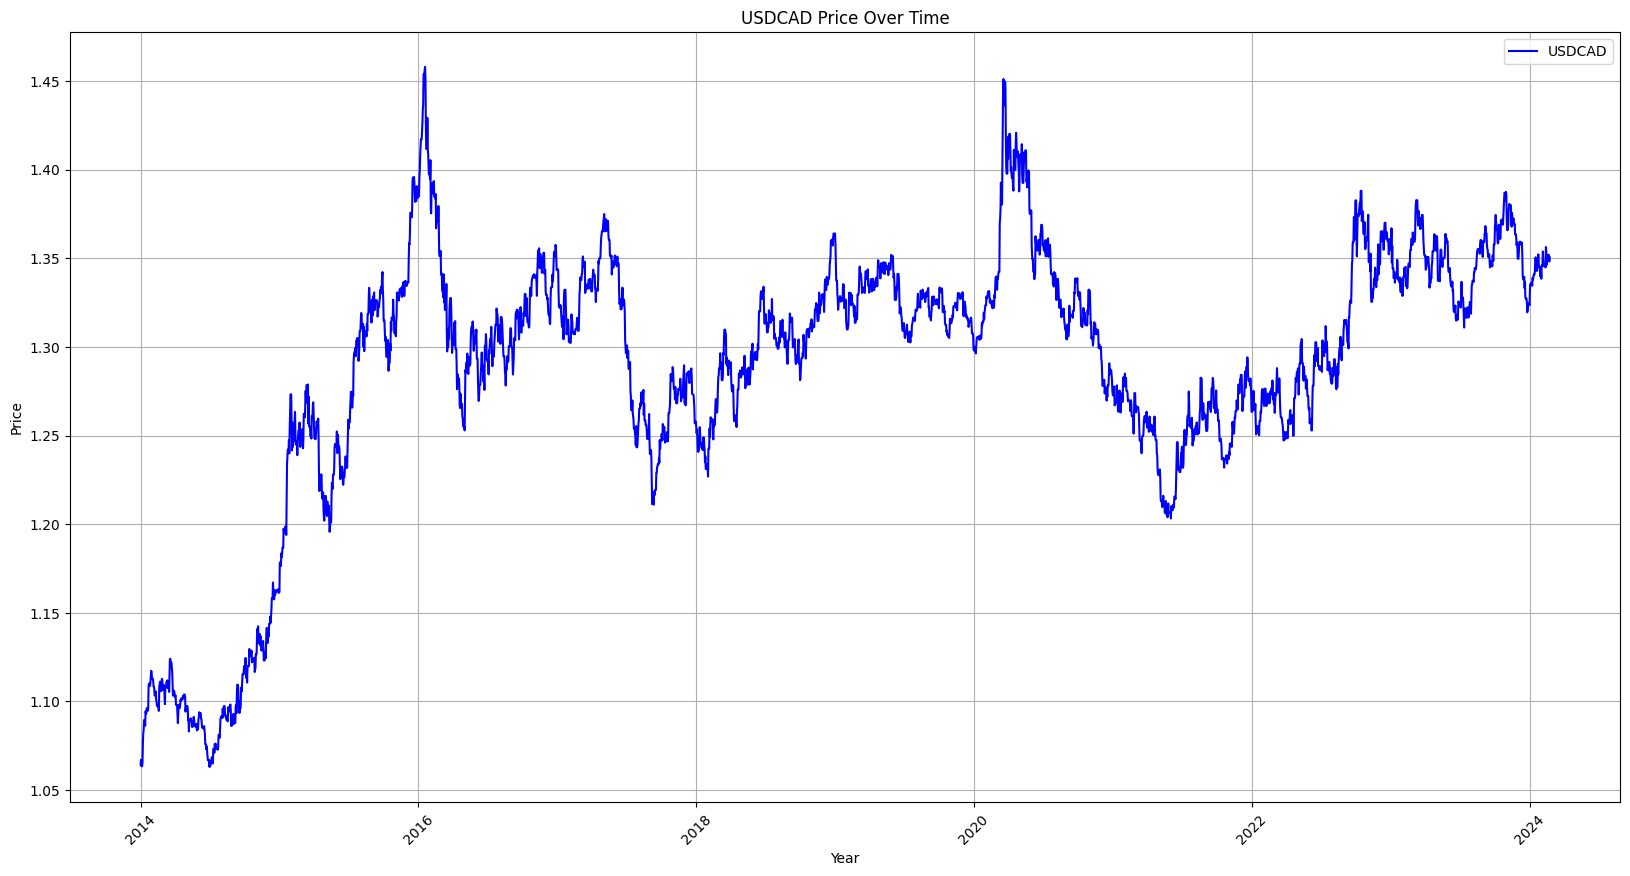

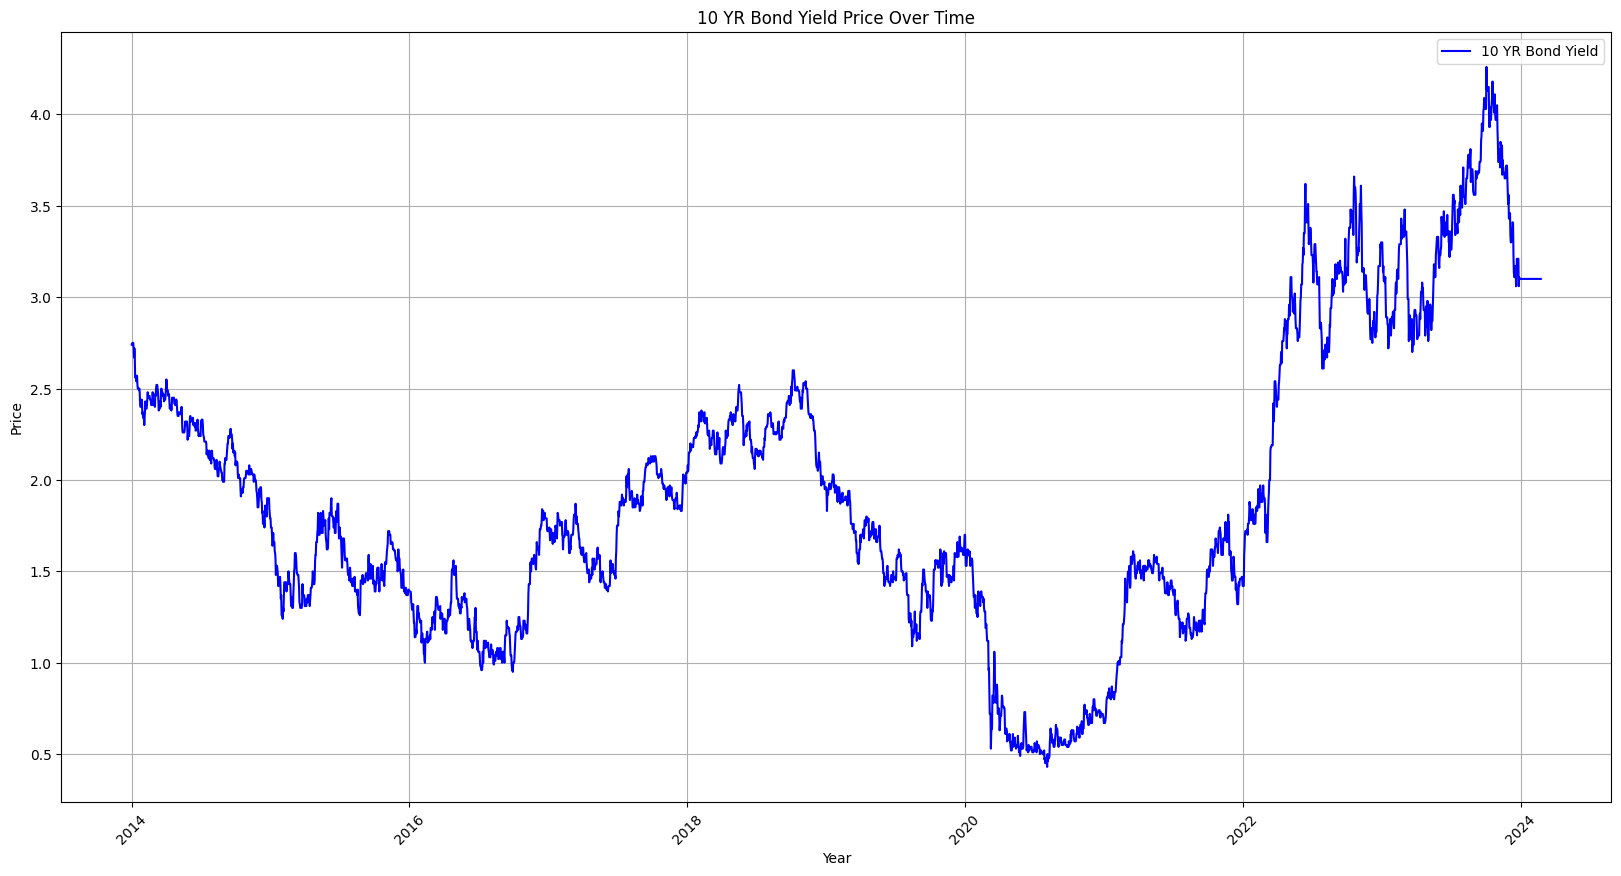

<Figure size 2000x1000 with 0 Axes>

In [79]:
for column in column_list:
    plot_line_chart(df.index,df[column], column)

## Correlation

In [26]:
# Correlation for all features
correlation_matrix = df.corr()
correlation_matrix

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA,RSI,Daily Volatility
WTI Price,1.000000,0.750450,NaN,-0.528782,0.328735,-0.255096,-0.494593,-0.313848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.212983,-0.484819,-0.454139,-0.228407,-0.593481,-0.379556,-0.595430,0.125789,-0.489875,0.512169,0.557486,0.471745,-0.494103,-0.184068,NaN,NaN,0.536290,-0.003193,0.639608,-0.174236,0.676926
Natural Gas Price,0.750450,1.000000,NaN,-0.826793,0.664253,-0.089724,-0.621921,-0.365112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.345021,-0.625410,-0.637698,-0.474057,-0.774842,-0.615993,-0.878679,0.030361,-0.795384,0.738979,0.728235,0.712383,-0.722130,-0.165184,NaN,NaN,0.783746,-0.032663,0.747872,-0.040680,0.814709
Aluminum Price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Copper Price,-0.528782,-0.826793,NaN,1.000000,-0.666945,0.092158,0.728712,0.229651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.423367,0.624866,0.768558,0.478163,0.843857,0.615158,0.843536,-0.025046,0.864713,-0.818954,-0.820970,-0.801992,0.761923,-0.016737,NaN,NaN,-0.825151,0.005194,-0.664207,-0.136071,-0.752572
Gold Price,0.328735,0.664253,NaN,-0.666945,1.000000,0.423617,-0.069521,0.085005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.070496,-0.300347,-0.298219,-0.229598,-0.602961,-0.317287,-0.631433,0.279688,-0.811180,0.756458,0.706974,0.725590,-0.809097,-0.353452,NaN,NaN,0.751970,0.213476,0.730738,0.323308,0.672565
Platinum Price,-0.255096,-0.089724,NaN,0.092158,0.423617,1.000000,0.335552,0.786468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.733033,0.647400,0.628871,0.622528,0.139185,0.601805,0.310169,0.807677,-0.295810,0.273285,0.310247,0.374702,-0.425665,0.024533,NaN,NaN,0.338310,0.083834,0.455377,0.791017,0.208491
Silver Price,-0.494593,-0.621921,NaN,0.728712,-0.069521,0.335552,1.000000,0.345730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374392,0.499004,0.660909,0.343246,0.585476,0.481349,0.588734,0.052946,0.527492,-0.489051,-0.547892,-0.521110,0.414737,-0.313156,NaN,NaN,-0.554088,0.256942,-0.415380,-0.017807,-0.543379
Lumber Price,-0.313848,-0.365112,NaN,0.229651,0.085005,0.786468,0.345730,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.828001,0.791669,0.716022,0.787774,0.236030,0.766561,0.554926,0.826106,-0.058799,0.049137,0.117139,0.199487,-0.237608,0.239941,NaN,NaN,0.152832,0.194055,0.239157,0.761279,0.076889
Interest_Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Correlation with just the target 
correlation_matrix['TSX']

WTI Price            0.125789
Natural Gas Price    0.030361
Aluminum Price            NaN
Copper Price        -0.025046
Gold Price           0.279688
Platinum Price       0.807677
Silver Price         0.052946
Lumber Price         0.826106
Interest_Rate             NaN
GDP                       NaN
CPI                       NaN
HPI                       NaN
Trade Balance             NaN
Unemployment              NaN
Wholesale Trade           NaN
US_GDP                    NaN
Housing starts            NaN
DAX                  0.800383
STOXX 50             0.642112
FTSE 100             0.545574
NASDAQ               0.752007
Nikkei 225          -0.049964
Russell 2000         0.644252
S&P 500              0.295528
TSX                  1.000000
CADJPY              -0.397075
EURCAD               0.415866
GBPCAD               0.493419
USDCAD               0.540526
10 YR Bond Yield    -0.573895
Index Up             0.238098
Year                      NaN
Month                     NaN
Day       

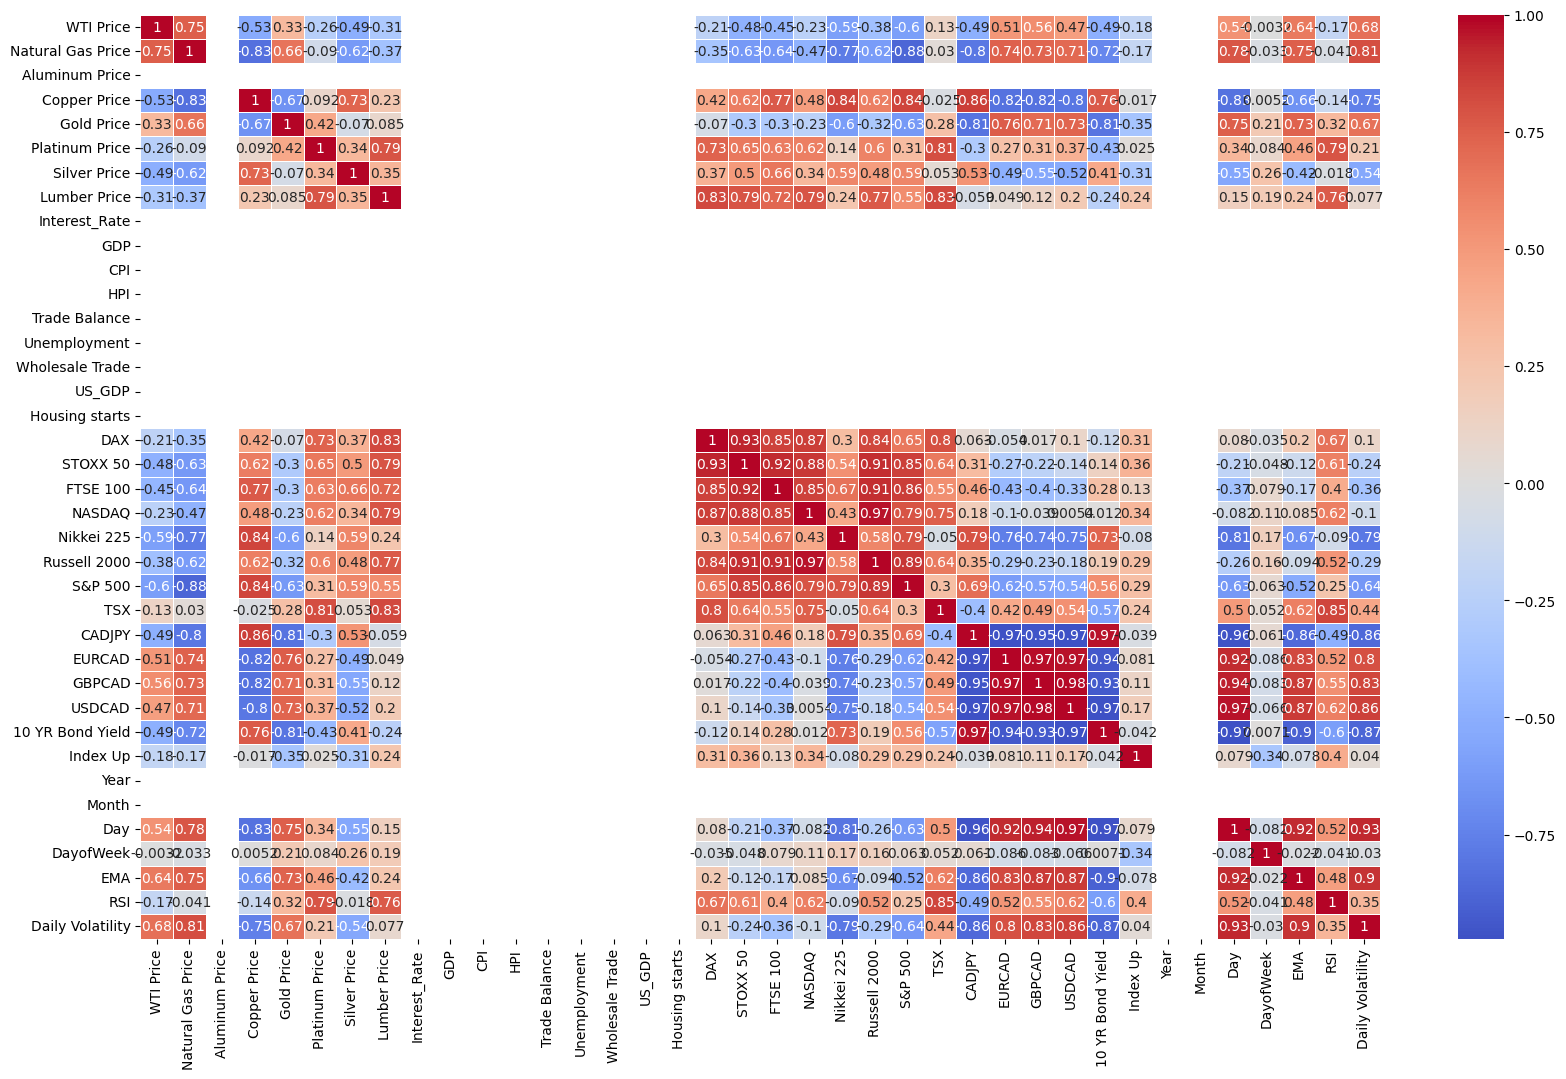

In [24]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()


In [25]:
# Identify upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop those features with correlation greater than 0.9
# Although TSX has correlation greater than 0.9 it will not be dropped
to_drop.remove('EMA')
to_drop.remove('TSX')
df_reduced = df.drop(columns=to_drop)

# Print the results
print(f"Features dropped: {to_drop}")
print(f"Remaining features: {df_reduced.columns.tolist()}")
print(f"Number of features remaining: {df_reduced.shape[1]}")

ValueError: list.remove(x): x not in list

In [ ]:
# Correlation for all features
correlation_matrix = df.corr()
correlation_matrix

# Identify upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop those features with correlation greater than 0.9
# Although TSX has correlation greater than 0.9 it will not be dropped
to_drop.remove('EMA')
to_drop.remove('TSX')
df_reduced = df.drop(columns=to_drop)

# Print the results
print(f"Features dropped: {to_drop}")
print(f"Remaining features: {df_reduced.columns.tolist()}")
print(f"Number of features remaining: {df_reduced.shape[1]}")

## IMPORT BASELINE DATAFRAME

In [311]:
with open('../data/models/baseline.pkl', 'rb') as file:
    df = pickle.load(file)

In [312]:
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4
2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,4,5
2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,5,6


# Feature Engineering

## Time-based Features: Exponential Moving Average
<p>An Exponential Moving Average (EMA) is a type of moving average that places a greater weight and significance on the most recent data points. It is commonly used in time series analysis, especially in financial markets, to smooth out data and identify trends more effectively than a simple moving average (SMA).</p>

In [313]:
n = 20 # period for the EMA. Used to track the trend of a stock over approximately one month, which is inline with other economic features.

df['EMA'] = df['TSX'].ewm(span=n, adjust=False).mean()
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857
2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,4,5,13585.966871
2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,5,6,13582.432883


In [314]:
# Computing the difference between consecutive EMA values, which essentially give the slope of the EMA
df['EMA Slope'] = df['EMA'].diff()
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA,EMA Slope
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000,NaN
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000,0.000000
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857,-4.317143
2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,4,5,13585.966871,-3.905986
2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,5,6,13582.432883,-3.533988


In [315]:
# EMA divided by the closing price of the TSX index
df['EMA/Close'] = df['EMA'] / df['TSX']
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA,EMA Slope,EMA/Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000,NaN,1.000000
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000,0.000000,1.000000
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857,-4.317143,1.003027
2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,4,5,13585.966871,-3.905986,1.002739
2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,5,6,13582.432883,-3.533988,1.002478


In [310]:
# The difference between the EMA and the TSX index. If TSX is greater than moving average value will be positive.
df['EMA Divergence'] = df['TSX'] - df['EMA']
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA,EMA Slope,EMA/Close,EMA Divergence
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000,NaN,1.000000,0.000000
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000,0.000000,1.000000,0.000000
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857,-4.317143,1.003027,-41.012857
2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,4,5,13585.966871,-3.905986,1.002739,-37.106871
2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,5,6,13582.432883,-3.533988,1.002478,-33.572883


## Technical Indicators: Relative Strength Index (RSI)
<p>The Relative Strength Index (RSI) is a momentum oscillator used in technical analysis that measures the speed and change of price movements. It is typically used to identify overbought or oversold conditions in a market. The RSI oscillates between 0 and 100, making it easy to interpret and apply in various trading strategies.</p>
<p>Below 30: The asset is generally considered oversold, indicating that it may be undervalued and due for a rebound. </p>
<p>Above 70: The asset is generally considered overbought, indicating that it may be overvalued and due for a correction or pullback.</p>

In [316]:
df['RSI'] = calculate_rsi(df['TSX'])

## Technical Indicators: Moving Average Convergence Divergence (MACD)

In [317]:
# Calculate the MACD line
df['MACD'] = df['TSX'].ewm(span=12, adjust=False).mean() - df['TSX'].ewm(span=26, adjust=False).mean()

In [318]:
# Calculate the Signal line (9-day EMA of MACD) 
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [319]:
# Calculate the MACD Histogram 
df['MACD Histogram'] = df['MACD'] - df['Signal Line']

In [320]:
# Drop the unnecessary MACD line and Signal line columns from features
df = df.drop(columns=['MACD', 'Signal Line'])

## Price Transformations: Daily Returns and Volatility
<p>Understanding the price fluctuations of a financial asset and measuring the risk associated with the asset on a daily basis.</p>

In [321]:
# Calculate Daily Returns
df['Daily Return'] = df['TSX'].pct_change()  

# Calculate the Rolling Standard Deviation of Daily Returns
df['Daily Volatility'] = df['Daily Return'].rolling(window=14).std()

df = df.drop(columns=['Daily Return']) # Simple returns is the same as the target variable, positive return equals index up, therefore will not include

In [147]:
print(df[['TSX', 'Daily Volatility']].tail())

                 TSX  Daily Volatility
Date                                  
2024-02-19  21255.61          0.009387
2024-02-20  21217.53          0.008907
2024-02-21  21172.38          0.008907
2024-02-22  21318.08          0.009055
2024-02-23  21413.15          0.009031


In [322]:
# Fill all NaN values with zero for EMA, RSI and Volatility
df = df.fillna(0)

In [323]:
df.head()

,WTI Price,Natural Gas Price,Aluminum Price,Copper Price,Gold Price,Platinum Price,Silver Price,Lumber Price,Interest_Rate,GDP,CPI,HPI,Trade Balance,Unemployment,Wholesale Trade,US_GDP,Housing starts,DAX,STOXX 50,FTSE 100,NASDAQ,Nikkei 225,Russell 2000,S&P 500,TSX,CADJPY,EURCAD,GBPCAD,USDCAD,10 YR Bond Yield,Index Up,Year,Month,Day,DayofWeek,EMA,EMA Slope,EMA/Close,RSI,MACD Histogram,Daily Volatility
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,4.232,1840.25,3.3815,1225.2,1377.05,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.88,1.4640,1.7634,1.0644,2.74,False,2014,1,1,2,13594.190000,0.000000,1.000000,0.0,0.000000,0.0
2014-01-02,95.44,4.321,1840.25,3.3815,1225.2,1402.30,20.128,353.3,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9400.04,3059.93,6717.91,4143.07,15908.88,1150.72,1831.98,13594.19,98.18,1.4589,1.7558,1.0671,2.74,False,2014,1,2,3,13594.190000,0.000000,1.000000,0.0,0.000000,0.0
2014-01-03,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,3,4,13589.872857,-4.317143,1.003027,0.0,-2.892855,0.0
2014-01-04,93.96,4.304,1840.25,3.3550,1238.6,1412.45,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,4,5,13585.966871,-3.905986,1.002739,0.0,-4.547798,0.0
2014-01-05,93.96,4.304,1840.25,3.3550,1238.6,1407.30,20.211,356.8,1.0,1863035.0,123.1,94.1,41334.2,7.7,50184932.0,1.719202e+13,33923.0,9435.15,3074.43,6730.67,4131.91,15908.88,1156.09,1831.37,13548.86,98.59,1.4452,1.7460,1.0635,2.75,False,2014,1,5,6,13582.432883,-3.533988,1.002478,0.0,-5.329723,0.0


In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3226 entries, 2014-01-01 to 2024-02-23
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WTI Price          3226 non-null   float64
 1   Natural Gas Price  3226 non-null   float64
 2   Aluminum Price     3226 non-null   float64
 3   Copper Price       3226 non-null   float64
 4   Gold Price         3226 non-null   float64
 5   Platinum Price     3226 non-null   float64
 6   Silver Price       3226 non-null   float64
 7   Lumber Price       3226 non-null   float64
 8   Interest_Rate      3226 non-null   float64
 9   GDP                3226 non-null   float64
 10  CPI                3226 non-null   float64
 11  HPI                3226 non-null   float64
 12  Trade Balance      3226 non-null   float64
 13  Unemployment       3226 non-null   float64
 14  Wholesale Trade    3226 non-null   float64
 15  US_GDP             3226 non-null   float64
 16  Housin

Remove correlation once EDA complete

In [160]:
# Correlation for all features
correlation_matrix = df.corr()
correlation_matrix

# Identify upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop those features with correlation greater than 0.9
# Although TSX has correlation greater than 0.9 it will not be dropped
#to_drop.remove('EMA')
to_drop.remove('TSX')
df_reduced = df.drop(columns=to_drop)

# Print the results
print(f"Features dropped: {to_drop}")
print(f"Remaining features: {df_reduced.columns.tolist()}")
print(f"Number of features remaining: {df_reduced.shape[1]}")

Features dropped: ['Copper Price', 'CPI', 'HPI', 'Trade Balance', 'Wholesale Trade', 'US_GDP', 'STOXX 50', 'NASDAQ', 'Nikkei 225', 'Russell 2000', 'S&P 500', 'Year']
Remaining features: ['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Gold Price', 'Platinum Price', 'Silver Price', 'Lumber Price', 'Interest_Rate', 'GDP', 'Unemployment', 'Housing starts', 'DAX', 'FTSE 100', 'TSX', 'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield', 'Index Up', 'Month', 'Day', 'DayofWeek']
Number of features remaining: 23


In [162]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3226 entries, 2014-01-01 to 2024-02-23
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WTI Price          3226 non-null   float64
 1   Natural Gas Price  3226 non-null   float64
 2   Aluminum Price     3226 non-null   float64
 3   Gold Price         3226 non-null   float64
 4   Platinum Price     3226 non-null   float64
 5   Silver Price       3226 non-null   float64
 6   Lumber Price       3226 non-null   float64
 7   Interest_Rate      3226 non-null   float64
 8   GDP                3226 non-null   float64
 9   Unemployment       3226 non-null   float64
 10  Housing starts     3226 non-null   float64
 11  DAX                3226 non-null   float64
 12  FTSE 100           3226 non-null   float64
 13  TSX                3226 non-null   float64
 14  CADJPY             3226 non-null   float64
 15  EURCAD             3226 non-null   float64
 16  GBPCAD

## Time-Series-Split Data for Time Series Data Set

In [325]:
X = df.drop(columns=['Index Up'])
y = df['Index Up']

In [326]:
tss = TimeSeriesSplit(n_splits=3)

In [327]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [328]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) # maintain column names
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [329]:
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

## Recursive Feature Elimination - Logistic Regression Model

In [55]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)

# Create an RFE object, specifying the model and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=15)

# Fit the RFE model on the data
rfe.fit(X_train_scaled, y_train)

# Get the rankings of the features
ranking = rfe.ranking_
selected_features = X_train_scaled.columns[rfe.support_]

print(f"Feature Rankings: {ranking}")
print(f"Selected Features: {selected_features.tolist()}")

Feature Rankings: [12  9 11  1  7  1  4  1  1  1  8  1  1  3  1  6  1  1  1 10  5  1  2  1
  1  1]
Selected Features: ['Gold Price', 'Silver Price', 'Interest_Rate', 'GDP', 'Unemployment', 'DAX', 'FTSE 100', 'CADJPY', 'GBPCAD', 'USDCAD', '10 YR Bond Yield', 'DayofWeek', 'RSI', 'Daily Volatility', 'EMA Slope']


In [52]:
print(X_train_scaled.columns)

Index(['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Gold Price',
       'Platinum Price', 'Silver Price', 'Lumber Price', 'Interest_Rate',
       'GDP', 'Unemployment', 'Housing starts', 'DAX', 'FTSE 100', 'TSX',
       'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield', 'Month',
       'Day', 'DayofWeek', 'EMA', 'RSI', 'Daily Volatility', 'EMA Slope'],
      dtype='object')


## Recursive Feature Elimination - Random Forrest Model

In [288]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create an RFE object, specifying the model and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=27)

# Fit the RFE model on the data
rfe.fit(X_train_scaled, y_train)

# Get the rankings of the features
ranking = rfe.ranking_
selected_features = X_train_scaled.columns[rfe.support_]

print(f"Feature Rankings: {ranking}")
print(f"Selected Features: {selected_features.tolist()}")

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train a model on the selected features
model.fit(X_train_rfe, y_train)
accuracy = model.score(X_test_rfe, y_test)
print("Model Accuracy with Selected Features:", accuracy)

Feature Rankings: [ 1  1  1  1  1  1  1  1 13  7  8 11  5  4  9 12 10  1  1  1  3  1  1  2
  1  1  1  1  1  1 14  6  1  1  1  1  1  1  1  1]
Selected Features: ['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Copper Price', 'Gold Price', 'Platinum Price', 'Silver Price', 'Lumber Price', 'DAX', 'STOXX 50', 'FTSE 100', 'Nikkei 225', 'Russell 2000', 'TSX', 'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield', 'Day', 'DayofWeek', 'EMA', 'EMA Slope', 'EMA/Close', 'RSI', 'MACD Histogram', 'Daily Volatility']
Model Accuracy with Selected Features: 0.7220843672456576


Number of features (Accuracy):

20 - 0.719

25 - 0.720

27 - 0.722

30 - 0.692

35 - 0.710

## Recursive Feature Elimination - XGBoost Model

In [330]:
model = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Create an RFE object, specifying the model and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=35)

# Fit the RFE model on the data
rfe.fit(X_train_scaled, y_train)

# Get the rankings of the features
ranking = rfe.ranking_
selected_features = X_train_scaled.columns[rfe.support_]

print(f"Feature Rankings: {ranking}")
print(f"Selected Features: {selected_features.tolist()}")

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train a model on the selected features
model.fit(X_train_rfe, y_train)
accuracy = model.score(X_test_rfe, y_test)
print("Model Accuracy with Selected Features:", accuracy)

Feature Rankings: [1 1 1 1 1 1 1 1 1 1 5 4 3 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1
 1 1 1]
Selected Features: ['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Copper Price', 'Gold Price', 'Platinum Price', 'Silver Price', 'Lumber Price', 'Interest_Rate', 'GDP', 'Unemployment', 'Wholesale Trade', 'Housing starts', 'DAX', 'STOXX 50', 'FTSE 100', 'NASDAQ', 'Nikkei 225', 'Russell 2000', 'S&P 500', 'TSX', 'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield', 'Month', 'Day', 'DayofWeek', 'EMA', 'EMA Slope', 'EMA/Close', 'RSI', 'MACD Histogram', 'Daily Volatility']
Model Accuracy with Selected Features: 0.7456575682382134


In [331]:
with open('../data/models/RFE_xgboost(0.746).pkl', 'wb') as file:
    pickle.dump(model, file)

Number of features (Accuracy):

20 - 0.738

25 - 0.741

27 - 0.742

30 - 0.730

35 - 0.746

## Feature Importance Using Random Forest Classifier

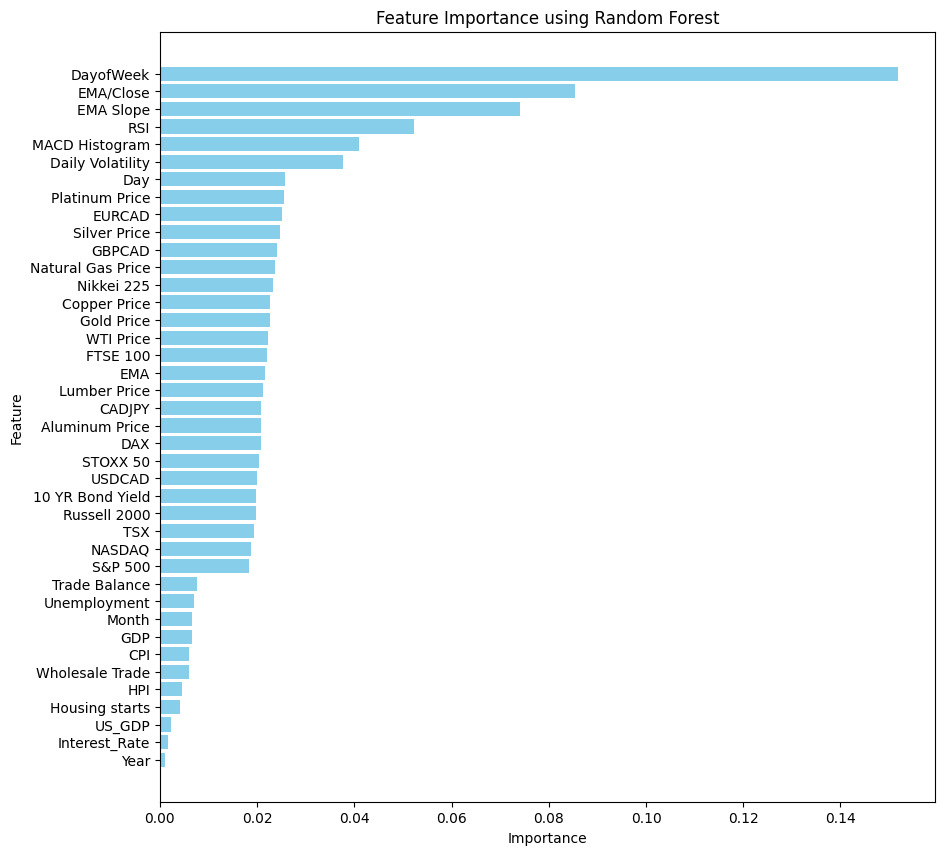

In [297]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using Random Forest')
plt.gca().invert_yaxis() # To display the most important feature at the top
plt.show()

In [301]:
X_train_scaled = X_train_scaled.drop(['Trade Balance', 'Unemployment', 'Month', 'GDP','CPI', 'Wholesale Trade', 'HPI', 'Housing starts', 'US_GDP', 'Interest_Rate', 'Year'], axis=1)

In [302]:
X_test_scaled = X_test_scaled.drop(['Trade Balance', 'Unemployment', 'Month', 'GDP','CPI', 'Wholesale Trade', 'HPI', 'Housing starts', 'US_GDP', 'Interest_Rate', 'Year'], axis=1)

In [303]:
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)